In [42]:
"""
Process Name : STEP 4 : TRAINING DATA WITH PERSONALITY FEATURE
"""
#=======================================================================================================
### Required Imports ###
#============================================================================================================
try:
    import sys  # System-specific parameters and functions
    import logging # for logs
    from datetime import datetime  # Date and time
    import socket # network communication
    import warnings  # Warning control
    import os # Interacting with the operating system
    import pandas as pd  # Data manipulation
    import numpy as np  # Numerical operations
    from sklearn.utils import resample  # Resampling utilities
    from imblearn.over_sampling import SMOTE  # Oversampling for imbalanced data
    from sklearn.ensemble import RandomForestClassifier  # Random Forest classifier
    import lightgbm as lgb  # LightGBM for boosting
    from sklearn.metrics import accuracy_score, confusion_matrix, classification_report  # Model evaluation metrics
    from sklearn.multioutput import MultiOutputClassifier  # Multi-output classifier wrapper
    from sklearn.model_selection import train_test_split  # Split dataset
    from sklearn.preprocessing import LabelEncoder  # Encode labels as integers
    from sklearn.cluster import KMeans  # K-means clustering
    from sklearn.preprocessing import StandardScaler  # Feature standardization
    import matplotlib.pyplot as plt  # Plotting
    from sklearn.preprocessing import MinMaxScaler  # Feature scaling
    from tensorflow.keras.models import Sequential  # Keras Sequential model
    from tensorflow.keras.callbacks import EarlyStopping  # Early stopping callback
    from sklearn.metrics import silhouette_score, precision_score, recall_score, f1_score, mean_squared_error, r2_score  # Various metrics
    from sklearn.ensemble import RandomForestRegressor  # Random Forest regressor
    from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense  # CNN layers
except Exception as err:
    print("Exception raised while importing the packages")
    print(f'Exception: {err}')
    #input("press Enter to Close")
    sys.exit()

In [43]:
#=========================================================================
### Initialization ###
#=========================================================================
try:
    path = os.getcwd()
    curr_time = datetime.now()

    ### Log Files declaration ###
    log_folder = os.path.join(path, 'Logs')
    log_date_fmt = str(curr_time.strftime('%Y')) + '-' + str(curr_time.strftime('%m')) + '-' + str(curr_time.strftime('%d')) + "_" + str(curr_time.strftime("%H")) + "-" + str(curr_time.strftime("%M"))

    audit_log_file = "Audit_training_evaluation_personalityee.log"
    audit_log_file = os.path.join(log_folder, audit_log_file)
    
    error_log_file = "Error_training_evaluation_personalityeee.log"
    error_log_file = os.path.join(log_folder, error_log_file)

    ### Creating log folder ###
    if not os.path.exists(log_folder):
        os.makedirs(log_folder)
        
    ### Function: Logger setup ###
    def setup_logger(logger_name, log_file, level=logging.INFO):
        logger = logging.getLogger(logger_name)
        formatter = logging.Formatter(socket.gethostname()+' : '+'%(asctime)s : %(levelname)s : [%(filename)s:%(lineno)d] : %(message)s')

        fileHandler = logging.FileHandler(log_file, mode='w')

        fileHandler.setFormatter(formatter)

        streamHandler = logging.StreamHandler(sys.stdout)
        streamHandler.setFormatter(formatter)

        logger.setLevel(level)
        logger.addHandler(fileHandler)
        logger.addHandler(streamHandler)
        return logger
        
    ### Setting up the logger ###
    setup_logger('audit', audit_log_file, level=logging.INFO)
    setup_logger('error', error_log_file, level=logging.ERROR)

    audit_logger = logging.getLogger('audit')
    error_logger = logging.getLogger('error')

    audit_logger.info('Process start')

except Exception as err:
    print('Setting up the logger failed')
    print(f'Exception: {err}')
    #input("press Enter to Close")
    sys.exit()

192.168.1.112 : 2024-09-01 21:02:14,533 : INFO : [308271807.py:46] : Process start
192.168.1.112 : 2024-09-01 21:02:14,533 : INFO : [308271807.py:46] : Process start


In [20]:
#==================================================================================================
### Ignore Warnings ### 
#==================================================================================================
try:
    audit_logger.info('Ignore Warnings')
    warnings.filterwarnings('ignore') ## Suppress all warnings
except Exception as err:
    audit_logger.info('Ignore Warnings - Failed')
    error_logger.error('Ignore Warnings - Failed')
    error_logger.error('Exception: ', exc_info=True)
    #input("press Enter to Close")
    sys.exit()

192.168.1.112 : 2024-09-01 20:48:40,395 : INFO : [2561458356.py:5] : Ignore Warnings


In [21]:
#==================================================================================================
### Create folder structure ### 
#==================================================================================================
try:
    audit_logger.info('Create folder structure')
    excel_folder = os.path.join(path, 'Excel_files')
    if not os.path.isdir(excel_folder):
        os.mkdir(excel_folder)
    saved_folder = os.path.join(path, 'Saved_files')
    if not os.path.isdir(saved_folder):
        os.mkdir(saved_folder)
    output_folder = os.path.join(path, 'Output')
    if not os.path.isdir(output_folder):
        os.mkdir(output_folder)
except Exception as err:
    audit_logger.info('Create folder structure - Failed')
    error_logger.error('Create folder structure - Failed')
    error_logger.error('Exception: ', exc_info=True)
    #input("press Enter to Close")
    sys.exit()

192.168.1.112 : 2024-09-01 20:48:40,963 : INFO : [4180990911.py:5] : Create folder structure


192.168.1.112 : 2024-09-01 17:02:24,635 : INFO : [507812218.py:5] : Cluster formation and applying smote and split


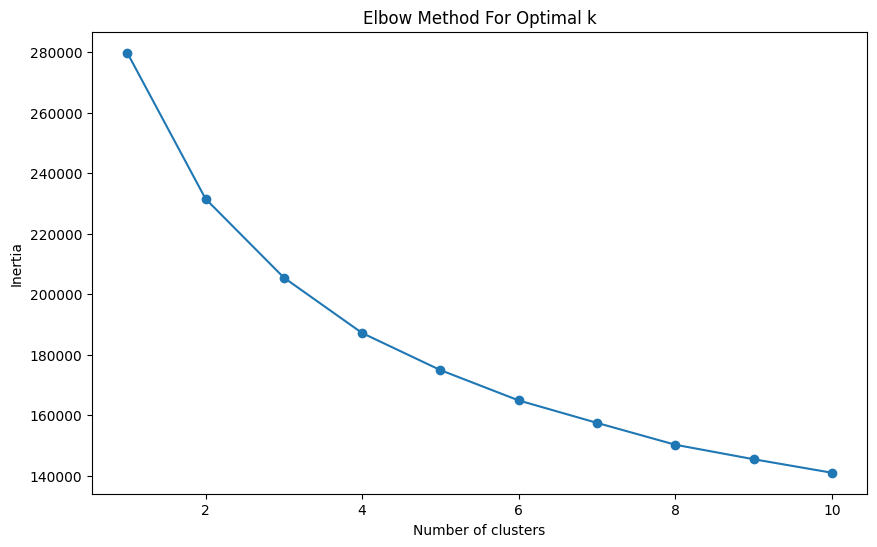

192.168.1.112 : 2024-09-01 17:02:34,511 : INFO : [507812218.py:43] : Silhouette Score: 0.235
192.168.1.112 : 2024-09-01 17:02:34,546 : INFO : [507812218.py:51] : Length of data before SMOTE: 13171
192.168.1.112 : 2024-09-01 17:02:34,613 : INFO : [507812218.py:63] : Length of data after smote: 21288


In [5]:
#==================================================================================================
### Cluster formation and applying smote and split ### 
#==================================================================================================
try:
    audit_logger.info('Cluster formation and applying smote and split')
    df = pd.read_excel(os.path.join(excel_folder, "preprocessed_data.xlsx"))
    eval_df = pd.read_excel(os.path.join(excel_folder,"evaluation_data_preprocessed.xlsx"))
    
    data_for_cluster = df[['Gender', 'Weight_kg', 'Height_cm','Preferred_Clothing_Type', 'Clothing_Size',
                           'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 
                           'Best_Color_Confidence_g','Best_Color_Confidence_b', 'birthplace_lat','birthplace_lon', 
                           'resi_lat', 'resi_lon', 'Age', "Personality"]]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data_for_cluster)
    
    # Determine the optimal number of clusters using the Elbow Method
    inertia = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_scaled)
        inertia.append(kmeans.inertia_)
    
    # Plotting the Elbow Curve
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 11), inertia, marker='o')
    plt.title('Elbow Method For Optimal k')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.savefig(os.path.join(saved_folder,'elbow_method_without_personality.png'), format='png', dpi=300) 
    plt.show()
    
    # Choose the optimal number of clusters
    k_optimal = 2
    kmeans = KMeans(n_clusters=k_optimal, random_state=42)
    kmeans.fit(X_scaled)
    clusters = kmeans.predict(X_scaled)
    
    # Add the cluster labels to your original dataframe
    data_for_cluster['Cluster'] = clusters
    df['Cluster'] = clusters

    score = silhouette_score(X_scaled, clusters)
    audit_logger.info('Silhouette Score: %.3f' % score)

    df.fillna(0, inplace=True)
    df=df.drop_duplicates()
    
    # Perform stratified train-test split
    X, y = df.drop('Preferred_Clothing', axis=1), df['Preferred_Clothing']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)
    audit_logger.info(f'Length of data before SMOTE: {len(X_train)}')
    
    # Apply SMOTE
    sm = SMOTE(random_state=123)
    X_res, y_res = sm.fit_resample(X_train, y_train)
    # Combine resampled data back into a DataFrame
    df_resampled = pd.DataFrame(X_res, columns=X.columns)
    df_resampled['Preferred_Clothing'] = y_res
    df_resampled.drop_duplicates(inplace=True)
    df_resampled.fillna(0, inplace=True)
    
    train_df=df_resampled.drop_duplicates()
    audit_logger.info(f'Length of data after smote: {len(train_df)}')  
    
    test_df = pd.concat([X_test, y_test], axis=1)
except Exception as err:
    audit_logger.info('Cluster formation and applying smote and split - Failed')
    error_logger.error('Cluster formation and applying smote and split - Failed')
    error_logger.error('Exception: ', exc_info=True)
    #input("press Enter to Close")
    sys.exit()

In [6]:
#==================================================================================================
### Train Test for Preferred_clothing ### 
#==================================================================================================
try:
    audit_logger.info('Train Test for Preferred_clothing')
    df_preferred_clothing_train = train_df[['Gender', 'Weight_kg', 'Height_cm','Preferred_Clothing_Type', 'Clothing_Size',
                       'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 
                       'Best_Color_Confidence_g','Best_Color_Confidence_b', 'birthplace_lat','birthplace_lon', 'Cluster',
                       'resi_lat', 'resi_lon', 'Age', 'Preferred_Clothing', 'Personality']]
    df_preferred_clothing_train.drop_duplicates(inplace=True)
    audit_logger.info(f'Training data size: {len(df_preferred_clothing_train)}')
    df_preferred_clothing_test = test_df[['Gender', 'Weight_kg', 'Height_cm','Preferred_Clothing_Type', 'Clothing_Size',
                           'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 
                           'Best_Color_Confidence_g','Best_Color_Confidence_b', 'birthplace_lat','birthplace_lon', 'Cluster',
                           'resi_lat', 'resi_lon', 'Age', 'Preferred_Clothing', 'Personality']]
    X_train_1 = df_preferred_clothing_train[['Gender', 'Weight_kg', 'Height_cm','Preferred_Clothing_Type', 'Clothing_Size',
                           'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Cluster',
                           'Best_Color_Confidence_g','Best_Color_Confidence_b', 'birthplace_lat','birthplace_lon', 
                           'resi_lat', 'resi_lon', 'Age', 'Personality']]
    X_test_1 = df_preferred_clothing_test[['Gender', 'Weight_kg', 'Height_cm','Preferred_Clothing_Type', 'Clothing_Size',
                           'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Cluster',
                           'Best_Color_Confidence_g','Best_Color_Confidence_b', 'birthplace_lat','birthplace_lon', 
                           'resi_lat', 'resi_lon', 'Age', 'Personality']]
    
    y_train_1 = df_preferred_clothing_train["Preferred_Clothing"]
    y_test_1 = df_preferred_clothing_test["Preferred_Clothing"]
    
    # Initialize and train RandomForest
    rf_model = RandomForestClassifier(criterion= 'gini', max_depth= None, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 250 , random_state=42)
    rf_model.fit(X_train_1, y_train_1)
    
    # Initialize and train LightGBM
    lgb_model = lgb.LGBMClassifier(boosting_type='dart', learning_rate=0.8, max_depth=12, n_estimators=200, num_leaves=158, subsample=0.4)
    lgb_model.fit(X_train_1, y_train_1)
    
    # Predict probabilities for the test set
    rf_probs = rf_model.predict_proba(X_test_1)[:, 1]  
    lgb_probs = lgb_model.predict_proba(X_test_1)[:, 1]
    
    # Blend the predictions by averaging
    blended_probs = (rf_probs + lgb_probs) / 2
    
    # Convert probabilities to final predictions based on a threshold
    final_predictions_test = (blended_probs > 0.50).astype(int)
    
    # Evaluate the blended model
    accuracy = accuracy_score(y_test, final_predictions_test)
    precision = precision_score(y_test, final_predictions_test, average='binary')  
    recall = recall_score(y_test, final_predictions_test, average='binary')       
    f1 = f1_score(y_test, final_predictions_test, average='binary') 
    audit_logger.info("Blended Model Accuracy: %.4f%%" % (accuracy * 100.0))
    audit_logger.info("Precision: %.4f" % (precision * 100.0))
    audit_logger.info("Recall: %.4f" % (recall * 100.0))
    audit_logger.info("F1 Score: %.4f" % (f1 * 100))
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test_1, final_predictions_test)
    audit_logger.info("Confusion Matrix:" % cm)
    
    # Extracting TP, TN, FP, FN
    tn, fp, fn, tp = cm.ravel()
    audit_logger.info(f"True Positives (TP): {tp}")
    audit_logger.info(f"False Positives (FP): {fp}")
    audit_logger.info(f"True Negatives (TN): {tn}")
    audit_logger.info(f"False Negatives (FN): {fn}")
except Exception as err:
    audit_logger.info('Train Test for Preferred_clothing - Failed')
    error_logger.error('Train Test for Preferred_clothing - Failed')
    error_logger.error('Exception: ', exc_info=True)
    #input("press Enter to Close")
    sys.exit()

192.168.1.112 : 2024-09-01 17:02:34,639 : INFO : [3299243014.py:5] : Train Test for Preferred_clothing
192.168.1.112 : 2024-09-01 17:02:34,654 : INFO : [3299243014.py:11] : Training data size: 10230
[LightGBM] [Info] Number of positive: 2130, number of negative: 8100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2910
[LightGBM] [Info] Number of data points in the train set: 10230, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.208211 -> initscore=-1.335742
[LightGBM] [Info] Start training from score -1.335742
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

In [7]:
#==================================================================================================
### Evaluation for Preferred_clothing ### 
#==================================================================================================
try:
    audit_logger.info('Evaluation for Preferred_clothing')
    data_for_cluster_eval = eval_df[['Gender', 'Weight_kg', 'Height_cm','Preferred_Clothing_Type', 'Clothing_Size',
                           'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 
                           'Best_Color_Confidence_g','Best_Color_Confidence_b', 'birthplace_lat','birthplace_lon',
                           'resi_lat', 'resi_lon', 'Age', 'Personality']]
    
    X_eval_scaled = scaler.transform(data_for_cluster_eval)
    eval_df['Cluster'] = kmeans.predict(X_eval_scaled)
    
    X_eval = eval_df[['Gender', 'Weight_kg', 'Height_cm','Preferred_Clothing_Type', 'Clothing_Size',
                           'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Cluster',
                           'Best_Color_Confidence_g','Best_Color_Confidence_b', 'birthplace_lat','birthplace_lon', 
                           'resi_lat', 'resi_lon', 'Age', 'Personality']]
    y_eval = eval_df[['Preferred_Clothing']]
    
    # Predict probabilities for the test set
    rf_probs = rf_model.predict_proba(X_eval)[:, 1]  
    lgb_probs = lgb_model.predict_proba(X_eval)[:, 1]
    
    # Blend the predictions by averaging
    blended_probs = (rf_probs + lgb_probs) / 2
    
    # Convert probabilities to final predictions based on a threshold
    final_predictions_eval = (blended_probs > 0.50).astype(int)
    
    # Evaluate the blended model
    accuracy = accuracy_score(y_eval, final_predictions_eval)
    precision = precision_score(y_eval, final_predictions_eval, average='binary')  
    recall = recall_score(y_eval, final_predictions_eval, average='binary')        
    f1 = f1_score(y_eval, final_predictions_eval, average='binary')                
    audit_logger.info("Blended Model Accuracy: %.4f%%" % (accuracy * 100.0))
    audit_logger.info("Precision: %.4f" % (precision * 100.0))
    audit_logger.info("Recall: %.4f" % (recall * 100.0))
    audit_logger.info("F1 Score: %.4f" % (f1 * 100))
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_eval, final_predictions_eval)
    audit_logger.info("Confusion Matrix:" % cm)
    
    # Extracting TP, TN, FP, FN
    tn, fp, fn, tp = cm.ravel()
    audit_logger.info(f"True Positives (TP): {tp}")
    audit_logger.info(f"False Positives (FP): {fp}")
    audit_logger.info(f"True Negatives (TN): {tn}")
    audit_logger.info(f"False Negatives (FN): {fn}")
except Exception as err:
    audit_logger.info('Evaluation for Preferred_clothing - Failed')
    error_logger.error('Evaluation for Preferred_clothing - Failed')
    error_logger.error('Exception: ', exc_info=True)
    #input("press Enter to Close")
    sys.exit()  

192.168.1.112 : 2024-09-01 17:02:38,649 : INFO : [1453635542.py:5] : Evaluation for Preferred_clothing
192.168.1.112 : 2024-09-01 17:02:38,702 : INFO : [1453635542.py:35] : Blended Model Accuracy: 84.9162%
192.168.1.112 : 2024-09-01 17:02:38,703 : INFO : [1453635542.py:36] : Precision: 93.3504
192.168.1.112 : 2024-09-01 17:02:38,704 : INFO : [1453635542.py:37] : Recall: 89.7909
192.168.1.112 : 2024-09-01 17:02:38,704 : INFO : [1453635542.py:38] : F1 Score: 91.5361
192.168.1.112 : 2024-09-01 17:02:38,709 : INFO : [1453635542.py:42] : Confusion Matrix:
192.168.1.112 : 2024-09-01 17:02:38,710 : INFO : [1453635542.py:46] : True Positives (TP): 730
192.168.1.112 : 2024-09-01 17:02:38,710 : INFO : [1453635542.py:47] : False Positives (FP): 52
192.168.1.112 : 2024-09-01 17:02:38,711 : INFO : [1453635542.py:48] : True Negatives (TN): 30
192.168.1.112 : 2024-09-01 17:02:38,711 : INFO : [1453635542.py:49] : False Negatives (FN): 83


In [8]:
#==================================================================================================
### Divide data for one piece wear and two piece wear ### 
#==================================================================================================
try:
    audit_logger.info('Divide data for one piece wear and two piece wear')
    # Convert y_pred to a DataFrame or Series
    y_pred_series = pd.Series(final_predictions_test, name='pred_Preferred_Clothing')
    
    # Ensure the indices match if they are not reset
    test_df = test_df.reset_index(drop=True)
    y_pred_series = y_pred_series.reset_index(drop=True)
    
    # Combine the predictions with the test DataFrame
    df_with_predictions = pd.concat([test_df, y_pred_series], axis=1) 
    df_with_piecewear_test = df_with_predictions[df_with_predictions["Preferred_Clothing"] == df_with_predictions["pred_Preferred_Clothing"]]
    
    # Convert y_pred to a DataFrame or Series
    y_pred_series = pd.Series(final_predictions_eval, name='pred_Preferred_Clothing')
    
    # Ensure the indices match if they are not reset
    eval_df = eval_df.reset_index(drop=True)
    y_pred_series = y_pred_series.reset_index(drop=True)
    
    # Combine the predictions with the test DataFrame
    eval_df_with_predictions = pd.concat([eval_df, y_pred_series], axis=1) 
    df_with_piecewear_eval = eval_df_with_predictions[eval_df_with_predictions["Preferred_Clothing"] == eval_df_with_predictions["pred_Preferred_Clothing"]]
except Exception as err:
    audit_logger.info('Divide data for one piece wear and two piece wear - Failed')
    error_logger.error('Divide data for one piece wear and two piece wear - Failed')
    error_logger.error('Exception: ', exc_info=True)
    #input("press Enter to Close")
    sys.exit() 


192.168.1.112 : 2024-09-01 17:02:38,721 : INFO : [3368686975.py:5] : Divide data for one piece wear and two piece wear


In [9]:
#==================================================================================================
### Train test classifier for two piece wear ### 
#==================================================================================================
try:
    audit_logger.info('Train test classifier for two piece wear')
    df_twopiece_test = df_with_piecewear_test[df_with_piecewear_test["Preferred_Clothing"] == 1]
    
    X_twopiece_test = df_twopiece_test[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type','Personality', 'Clothing_Size','Favourite_Color_r', 
              'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 
              'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age']]
    y_twopiece_test = df_twopiece_test[['Preferred_Bottoms', 'Bottoms_Material','Bottoms_Length', 'Bottoms_Fitting', 'Preferred_Upperwear',
           'Upperwear_Material', 'Upperwear_Length', 'Upperwear_Neckline','Upperwear_Sleeve_Type', 'Upperwear_Pattern']]
    
    df_twopiece_train = train_df[train_df["Preferred_Clothing"] == 1]
    df_twopiece_train = df_twopiece_train[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type','Personality', 'Clothing_Size','Favourite_Color_r', 
              'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 
              'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age', 
                'Preferred_Bottoms', 'Bottoms_Material','Bottoms_Length', 'Bottoms_Fitting', 'Preferred_Upperwear',
           'Upperwear_Material', 'Upperwear_Length', 'Upperwear_Neckline','Upperwear_Sleeve_Type', 'Upperwear_Pattern']]
    df_twopiece_train.drop_duplicates(inplace=True)
    audit_logger.info(f'Training data size: {len(df_twopiece_train)}')
    X_twopiece_train = df_twopiece_train[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type','Personality', 'Clothing_Size','Favourite_Color_r', 
              'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 
              'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age']]
    y_twopiece_train = df_twopiece_train[['Preferred_Bottoms', 'Bottoms_Material','Bottoms_Length', 'Bottoms_Fitting', 'Preferred_Upperwear',
           'Upperwear_Material', 'Upperwear_Length', 'Upperwear_Neckline','Upperwear_Sleeve_Type', 'Upperwear_Pattern']]
    
    # Initialize a Random Forest Classifier
    rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, criterion='entropy', random_state=42)
    # Wrap it in the MultiOutputClassifier
    multi_rf_classifier = MultiOutputClassifier(rf_classifier)
    
    # Training the classifier
    multi_rf_classifier.fit(X_twopiece_train, y_twopiece_train)
    
    # Predicting the test set results
    y_pred_test = multi_rf_classifier.predict(X_twopiece_test)

    # Lists to store metrics for each label
    accuracies = []
    macro_precisions = []
    macro_recalls = []
    macro_f1_scores = []
    micro_precisions = []
    micro_recalls = []
    micro_f1_scores = []
    
    # Iterate over each target column
    for i in range(y_twopiece_test.shape[1]):
        accuracies.append(accuracy_score(y_twopiece_test.iloc[:, i], y_pred_test[:, i]))
        macro_precisions.append(precision_score(y_twopiece_test.iloc[:, i], y_pred_test[:, i], average="macro", zero_division=0))
        macro_recalls.append(recall_score(y_twopiece_test.iloc[:, i], y_pred_test[:, i], average="macro", zero_division=0))
        macro_f1_scores.append(f1_score(y_twopiece_test.iloc[:, i], y_pred_test[:, i], average="macro", zero_division=0))
        micro_precisions.append(precision_score(y_twopiece_test.iloc[:, i], y_pred_test[:, i], average="micro", zero_division=0))
        micro_recalls.append(recall_score(y_twopiece_test.iloc[:, i], y_pred_test[:, i], average="micro", zero_division=0))
        micro_f1_scores.append(f1_score(y_twopiece_test.iloc[:, i], y_pred_test[:, i], average="micro", zero_division=0))
        
    # Output the calculated metrics for each target
    for i, column in enumerate(y_twopiece_test.columns):
        audit_logger.info(f"Metrics for {column}:")
        audit_logger.info(f"  Accuracy: {accuracies[i]:.4f}")
        audit_logger.info(f"  Macro Precision: {macro_precisions[i]:.4f}")
        audit_logger.info(f"  Macro Recall: {macro_recalls[i]:.4f}")
        audit_logger.info(f"  Macro F1 Score: {macro_f1_scores[i]:.4f}")
        audit_logger.info(f"  Micro Precision: {micro_precisions[i]:.4f}")
        audit_logger.info(f"  Micro Recall: {micro_recalls[i]:.4f}")
        audit_logger.info(f"  Micro F1 Score: {micro_f1_scores[i]:.4f}")
        audit_logger.info("\n" + "-"*80 + "\n")
    
    # Calculate overall metrics by averaging
    overall_accuracy = sum(accuracies) / len(accuracies)
    overall_macro_precision = sum(macro_precisions) / len(macro_precisions)
    overall_macro_recall = sum(macro_recalls) / len(macro_recalls)
    overall_macro_f1 = sum(macro_f1_scores) / len(macro_f1_scores)
    overall_micro_precision = sum(micro_precisions) / len(micro_precisions)
    overall_micro_recall = sum(micro_recalls) / len(micro_recalls)
    overall_micro_f1 = sum(micro_f1_scores) / len(micro_f1_scores)
    
    audit_logger.info("\nOverall Metrics:")
    audit_logger.info(f"  Overall Accuracy: {overall_accuracy:.4f}")
    audit_logger.info(f"  Overall Macro Precision: {overall_macro_precision:.4f}")
    audit_logger.info(f"  Overall Macro Recall: {overall_macro_recall:.4f}")
    audit_logger.info(f"  Overall Macro F1 Score: {overall_macro_f1:.4f}")
    audit_logger.info(f"  Overall Micro Precision: {overall_micro_precision:.4f}")
    audit_logger.info(f"  Overall Micro Recall: {overall_micro_recall:.4f}")
    audit_logger.info(f"  Overall Micro F1 Score: {overall_micro_f1:.4f}")

    #Adding values in the common dataframe
    column_name = ["pred_"+col for col in y_twopiece_test.columns]
    y_pred_df = pd.DataFrame(y_pred_test, columns=column_name, index=y_twopiece_test.index)
    df_with_predictions = pd.merge(df_with_predictions, y_pred_df, left_index=True, right_index=True, how='left')
except Exception as err:
    audit_logger.info('Train test classifier for two piece wear - Failed')
    error_logger.error('Train test classifier for two piece wear - Failed')
    error_logger.error('Exception: ', exc_info=True)
    #input("press Enter to Close")
    sys.exit() 

192.168.1.112 : 2024-09-01 17:02:38,745 : INFO : [3647212635.py:5] : Train test classifier for two piece wear
192.168.1.112 : 2024-09-01 17:02:38,760 : INFO : [3647212635.py:21] : Training data size: 4399
192.168.1.112 : 2024-09-01 17:02:46,199 : INFO : [3647212635.py:60] : Metrics for Preferred_Bottoms:
192.168.1.112 : 2024-09-01 17:02:46,202 : INFO : [3647212635.py:61] :   Accuracy: 0.8855
192.168.1.112 : 2024-09-01 17:02:46,202 : INFO : [3647212635.py:62] :   Macro Precision: 0.8946
192.168.1.112 : 2024-09-01 17:02:46,202 : INFO : [3647212635.py:63] :   Macro Recall: 0.8882
192.168.1.112 : 2024-09-01 17:02:46,203 : INFO : [3647212635.py:64] :   Macro F1 Score: 0.8913
192.168.1.112 : 2024-09-01 17:02:46,203 : INFO : [3647212635.py:65] :   Micro Precision: 0.8855
192.168.1.112 : 2024-09-01 17:02:46,203 : INFO : [3647212635.py:66] :   Micro Recall: 0.8855
192.168.1.112 : 2024-09-01 17:02:46,204 : INFO : [3647212635.py:67] :   Micro F1 Score: 0.8855
192.168.1.112 : 2024-09-01 17:02:46,2

In [10]:
#==================================================================================================
### Evaluation for two piece wear classifier ### 
#==================================================================================================
try:
    audit_logger.info('Evaluation for two piece wear classifier')
    df_twopiece_eval = df_with_piecewear_eval[df_with_piecewear_eval["Preferred_Clothing"] == 1]
    
    X_twopiece_eval = df_twopiece_eval[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type','Personality', 'Clothing_Size','Favourite_Color_r', 
              'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 
              'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age']]
    y_twopiece_eval = df_twopiece_eval[['Preferred_Bottoms', 'Bottoms_Material','Bottoms_Length', 'Bottoms_Fitting', 'Preferred_Upperwear',
           'Upperwear_Material', 'Upperwear_Length', 'Upperwear_Neckline','Upperwear_Sleeve_Type', 'Upperwear_Pattern']]
    
    # Predicting the test set results
    y_pred_eval = multi_rf_classifier.predict(X_twopiece_eval)
    
    # Initialize lists to store the metrics for each target
    accuracies = []
    macro_precisions = []
    macro_recalls = []
    macro_f1_scores = []
    micro_precisions = []
    micro_recalls = []
    micro_f1_scores = []
    
    # Iterate over each target column
    for i in range(y_twopiece_eval.shape[1]):
        accuracies.append(accuracy_score(y_twopiece_eval.iloc[:, i], y_pred_eval[:, i]))
        macro_precisions.append(precision_score(y_twopiece_eval.iloc[:, i], y_pred_eval[:, i], average='macro', zero_division=0))
        macro_recalls.append(recall_score(y_twopiece_eval.iloc[:, i], y_pred_eval[:, i], average='macro', zero_division=0))
        macro_f1_scores.append(f1_score(y_twopiece_eval.iloc[:, i], y_pred_eval[:, i], average='macro', zero_division=0))
        micro_precisions.append(precision_score(y_twopiece_eval.iloc[:, i], y_pred_eval[:, i], average='micro', zero_division=0))
        micro_recalls.append(recall_score(y_twopiece_eval.iloc[:, i], y_pred_eval[:, i], average='micro', zero_division=0))
        micro_f1_scores.append(f1_score(y_twopiece_eval.iloc[:, i], y_pred_eval[:, i], average='micro', zero_division=0))
    
    # Output the calculated metrics for each target
    for i, column in enumerate(y_twopiece_train.columns):
        audit_logger.info(f"Metrics for {column}:")
        audit_logger.info(f"  Accuracy: {accuracies[i]:.4f}")
        audit_logger.info(f"  Macro Precision: {macro_precisions[i]:.4f}")
        audit_logger.info(f"  Macro Recall: {macro_recalls[i]:.4f}")
        audit_logger.info(f"  Macro F1 Score: {macro_f1_scores[i]:.4f}")
        audit_logger.info(f"  Micro Precision: {micro_precisions[i]:.4f}")
        audit_logger.info(f"  Micro Recall: {micro_recalls[i]:.4f}")
        audit_logger.info(f"  Micro F1 Score: {micro_f1_scores[i]:.4f}")
        audit_logger.info("\n" + "-"*80 + "\n")
    
    # Calculate overall metrics by averaging
    average_accuracy = sum(accuracies) / len(accuracies)
    average_macro_precision = sum(macro_precisions) / len(macro_precisions)
    average_macro_recall = sum(macro_recalls) / len(macro_recalls)
    average_macro_f1 = sum(macro_f1_scores) / len(macro_f1_scores)
    average_micro_precision = sum(micro_precisions) / len(micro_precisions)
    average_micro_recall = sum(micro_recalls) / len(micro_recalls)
    average_micro_f1 = sum(micro_f1_scores) / len(micro_f1_scores)
    
    audit_logger.info("\nOverall Metrics:")
    audit_logger.info(f"  Overall Accuracy: {overall_accuracy:.4f}")
    audit_logger.info(f"  Overall Macro Precision: {overall_macro_precision:.4f}")
    audit_logger.info(f"  Overall Macro Recall: {overall_macro_recall:.4f}")
    audit_logger.info(f"  Overall Macro F1 Score: {overall_macro_f1:.4f}")
    audit_logger.info(f"  Overall Micro Precision: {overall_micro_precision:.4f}")
    audit_logger.info(f"  Overall Micro Recall: {overall_micro_recall:.4f}")
    audit_logger.info(f"  Overall Micro F1 Score: {overall_micro_f1:.4f}")

    #Adding values in the common dataframe
    column_name = ["pred_"+col for col in y_twopiece_eval.columns]
    y_pred_df = pd.DataFrame(y_pred_eval, columns=column_name, index=y_twopiece_eval.index)
    eval_df_with_predictions = pd.merge(eval_df_with_predictions, y_pred_df, left_index=True, right_index=True, how='left')
except Exception as err:
    audit_logger.info('Evaluation for two piece wear classifier - Failed')
    error_logger.error('Evaluation for two piece wear classifier - Failed')
    error_logger.error('Exception: ', exc_info=True)
    #input("press Enter to Close")
    sys.exit()    


192.168.1.112 : 2024-08-30 17:20:26,377 : INFO : [3450908091.py:5] : Evaluation for two piece wear classifier
192.168.1.112 : 2024-08-30 17:20:26,627 : INFO : [3450908091.py:38] : Metrics for Preferred_Bottoms:
192.168.1.112 : 2024-08-30 17:20:26,627 : INFO : [3450908091.py:39] :   Accuracy: 0.4753
192.168.1.112 : 2024-08-30 17:20:26,628 : INFO : [3450908091.py:40] :   Macro Precision: 0.1646
192.168.1.112 : 2024-08-30 17:20:26,628 : INFO : [3450908091.py:41] :   Macro Recall: 0.1421
192.168.1.112 : 2024-08-30 17:20:26,628 : INFO : [3450908091.py:42] :   Macro F1 Score: 0.1297
192.168.1.112 : 2024-08-30 17:20:26,629 : INFO : [3450908091.py:43] :   Micro Precision: 0.4753
192.168.1.112 : 2024-08-30 17:20:26,629 : INFO : [3450908091.py:44] :   Micro Recall: 0.4753
192.168.1.112 : 2024-08-30 17:20:26,629 : INFO : [3450908091.py:45] :   Micro F1 Score: 0.4753
192.168.1.112 : 2024-08-30 17:20:26,629 : INFO : [3450908091.py:46] : 
-------------------------------------------------------------

In [11]:
#==================================================================================================
### Deeplearning model for two piece wear color### 
#==================================================================================================
try:
    audit_logger.info('Train test regressor for two piece wear')

    # Data preparation (assuming the code to prepare df_color_twopiece_train and df_twopiece_test is the same as before)
    X_color_twopiece_test = df_twopiece_test[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type','Personality', 'Clothing_Size','Favourite_Color_r', 
               'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 
               'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age']]
    y_color_twopiece_test = df_twopiece_test[['Preferred_Bottoms', 'Bottoms_Color_r', 'Bottoms_Color_g','Bottoms_Color_b', 'Preferred_Upperwear',
           'Upperwear_Color_r', 'Upperwear_Color_g', 'Upperwear_Color_b']]
    df_color_twopiece_train = train_df[train_df["Preferred_Clothing"] == 1]
    df_color_twopiece_train = df_color_twopiece_train[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type','Personality', 'Clothing_Size','Favourite_Color_r', 
               'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 
               'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age', 
                'Preferred_Bottoms', 'Bottoms_Color_r', 'Bottoms_Color_g','Bottoms_Color_b', 'Preferred_Upperwear',
           'Upperwear_Color_r', 'Upperwear_Color_g', 'Upperwear_Color_b']]
    df_color_twopiece_train.drop_duplicates(inplace=True)
    X_color_twopiece_train = df_color_twopiece_train[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type','Personality', 'Clothing_Size','Favourite_Color_r', 
               'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 
               'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age']]
    y_color_twopiece_train = df_color_twopiece_train[['Preferred_Bottoms', 'Bottoms_Color_r', 'Bottoms_Color_g','Bottoms_Color_b', 'Preferred_Upperwear',
           'Upperwear_Color_r', 'Upperwear_Color_g', 'Upperwear_Color_b']]
    
    # Normalize features and targets with StandardScaler
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_scaled = scaler_X.fit_transform(X_color_twopiece_train)
    y_scaled = scaler_y.fit_transform(y_color_twopiece_train)
    X_test_scaled = scaler_X.transform(X_color_twopiece_test)
    y_test_scaled = scaler_y.transform(y_color_twopiece_test)
    
    # Reshape input to be [samples, features, 1] for 1D CNN
    X_scaled = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))
    X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
    
    # Build 1D CNN model
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_scaled.shape[1], 1)),
        MaxPooling1D(pool_size=5),
        Flatten(),
        Dense(100, activation='relu'),
        Dense(y_scaled.shape[1])
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    
    # Implement early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model
    model.fit(X_scaled, y_scaled, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test_scaled), callbacks=[early_stopping])
    
    # Evaluate the model
    test_loss = model.evaluate(X_test_scaled, y_test_scaled)
    audit_logger.info(f'Test Loss: {test_loss}')
except Exception as err:
    audit_logger.info('Deeplearning model for two piece wear color - Failed')
    error_logger.error('Deeplearning model for two piece wear color - Failed')
    error_logger.error('Exception: ', exc_info=True)
    #input("press Enter to Close")
    sys.exit() 

192.168.1.112 : 2024-08-30 17:20:26,701 : INFO : [623881406.py:5] : Train test regressor for two piece wear


2024-08-30 17:20:26.760056: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-30 17:20:26.760196: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2024-08-30 17:20:27.796481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-30 17:20:27.865641: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


226/226 [==============================] - ETA: 0s - loss: 1.0027 - mean_squared_error: 1.0027

2024-08-30 17:20:31.657472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


226/226 [==============================] - 5s 18ms/step - loss: 1.0027 - mean_squared_error: 1.0027 - val_loss: 1.0171 - val_mean_squared_error: 1.0171
Epoch 2/100
226/226 [==============================] - 4s 19ms/step - loss: 0.9870 - mean_squared_error: 0.9870 - val_loss: 1.0036 - val_mean_squared_error: 1.0036
Epoch 3/100
226/226 [==============================] - 3s 14ms/step - loss: 0.9820 - mean_squared_error: 0.9820 - val_loss: 0.9977 - val_mean_squared_error: 0.9977
Epoch 4/100
226/226 [==============================] - 3s 14ms/step - loss: 0.9801 - mean_squared_error: 0.9801 - val_loss: 1.0019 - val_mean_squared_error: 1.0019
Epoch 5/100
226/226 [==============================] - 3s 14ms/step - loss: 0.9793 - mean_squared_error: 0.9793 - val_loss: 1.0111 - val_mean_squared_error: 1.0111
Epoch 6/100
226/226 [==============================] - 3s 15ms/step - loss: 0.9764 - mean_squared_error: 0.9764 - val_loss: 1.0042 - val_mean_squared_error: 1.0042
Epoch 7/100
226/226 [=======

In [12]:
#==================================================================================================
### Deeplearning model evaluation for two piece wear color ### 
#==================================================================================================
try:
    audit_logger.info('Deeplearning model evaluation for two piece wear color')
    X_color_twopiece_eval = df_twopiece_eval[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type','Personality', 'Clothing_Size','Favourite_Color_r', 
               'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 
               'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age']]
    y_color_twopiece_eval = df_twopiece_eval[['Preferred_Bottoms', 'Bottoms_Color_r', 'Bottoms_Color_g','Bottoms_Color_b', 'Preferred_Upperwear',
           'Upperwear_Color_r', 'Upperwear_Color_g', 'Upperwear_Color_b']]
    
    X_eval_scaled = scaler_X.transform(X_color_twopiece_eval)
    y_eval_scaled = scaler_y.transform(y_color_twopiece_eval)
    
    X_eval_scaled = X_eval_scaled.reshape((X_eval_scaled.shape[0], X_eval_scaled.shape[1], 1))
    
    # Evaluate the model
    test_loss = model.evaluate(X_eval_scaled, y_eval_scaled)
    audit_logger.info(f'Test Loss: {test_loss}')
except Exception as err:
    audit_logger.info('Deeplearning model evaluation for two piece wear color - Failed')
    error_logger.error('Deeplearning model evaluation for two piece wear color - Failed')
    error_logger.error('Exception: ', exc_info=True)
    #input("press Enter to Close")
    sys.exit()  

192.168.1.112 : 2024-08-30 17:21:23,494 : INFO : [3669244548.py:5] : Deeplearning model evaluation for two piece wear color
23/23 [==============================] - 0s 7ms/step - loss: 1.0366 - mean_squared_error: 1.0366
192.168.1.112 : 2024-08-30 17:21:23,706 : INFO : [3669244548.py:19] : Test Loss: [1.0365501642227173, 1.0365501642227173]


In [13]:
#==================================================================================================
### Train test classifier for one piece wear ### 
#==================================================================================================
try:
    audit_logger.info('Train test classifier for one piece wear')
    df_onepiece_test = df_with_piecewear_test[df_with_piecewear_test["Preferred_Clothing"] == 0]
    
    X_onepiece_test = df_onepiece_test[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type','Personality', 'Clothing_Size','Favourite_Color_r', 
              'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 
              'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age']]
    y_onepiece_test = df_onepiece_test[['Favourite_Single_Piece', 'Single_Piece_Material', 'Single_Piece_Fitting', 'Single_Piece_Length',
              'Single_Piece_Sleeves', 'Single_Piece_Neckline', 'Single_Piece_Pattern']]
    
    df_onepiece_train = train_df[train_df["Preferred_Clothing"] == 0]
    df_onepiece_train = df_onepiece_train[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type','Personality', 'Clothing_Size','Favourite_Color_r', 
            'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 
            'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age', 'Favourite_Single_Piece', 'Single_Piece_Material', 
            'Single_Piece_Fitting', 'Single_Piece_Length','Single_Piece_Sleeves', 'Single_Piece_Neckline', 'Single_Piece_Pattern']]
    df_onepiece_train.drop_duplicates(inplace=True)
    audit_logger.info(f'Training data size: {len(df_onepiece_train)}')
    X_onepiece_train = df_onepiece_train[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type','Personality', 'Clothing_Size','Favourite_Color_r', 
              'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 
              'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age']]
    y_onepiece_train = df_onepiece_train[['Favourite_Single_Piece', 'Single_Piece_Material', 'Single_Piece_Fitting', 'Single_Piece_Length',
              'Single_Piece_Sleeves', 'Single_Piece_Neckline', 'Single_Piece_Pattern']]
    
    # Initialize a Random Forest Classifier
    rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=None, min_samples_leaf=1, min_samples_split= 2, n_estimators=200, random_state=42)
    
    # Wrap it in the MultiOutputClassifier
    multi_rf_classifier = MultiOutputClassifier(rf_classifier)
    
    # Training the classifier
    multi_rf_classifier.fit(X_onepiece_train, y_onepiece_train)
    
    # Predicting the test set results
    y_pred_test = multi_rf_classifier.predict(X_onepiece_test)
    
    # Initialize lists to store the metrics for each target
    accuracies = []
    macro_precisions = []
    macro_recalls = []
    macro_f1_scores = []
    micro_precisions = []
    micro_recalls = []
    micro_f1_scores = []
    
    # Iterate over each target column
    for i in range(y_onepiece_test.shape[1]):
        accuracies.append(accuracy_score(y_onepiece_test.iloc[:, i], y_pred_test[:, i]))
        macro_precisions.append(precision_score(y_onepiece_test.iloc[:, i], y_pred_test[:, i], average='macro', zero_division=0))
        macro_recalls.append(recall_score(y_onepiece_test.iloc[:, i], y_pred_test[:, i], average='macro', zero_division=0))
        macro_f1_scores.append(f1_score(y_onepiece_test.iloc[:, i], y_pred_test[:, i], average='macro', zero_division=0))
        micro_precisions.append(precision_score(y_onepiece_test.iloc[:, i], y_pred_test[:, i], average='micro', zero_division=0))
        micro_recalls.append(recall_score(y_onepiece_test.iloc[:, i], y_pred_test[:, i], average='micro', zero_division=0))
        micro_f1_scores.append(f1_score(y_onepiece_test.iloc[:, i], y_pred_test[:, i], average='micro', zero_division=0))
    
    # Output the calculated metrics for each target
    for i, column in enumerate(y_onepiece_train.columns):
        audit_logger.info(f"Metrics for {column}:")
        audit_logger.info(f"  Accuracy: {accuracies[i]:.4f}")
        audit_logger.info(f"  Macro Precision: {macro_precisions[i]:.4f}")
        audit_logger.info(f"  Macro Recall: {macro_recalls[i]:.4f}")
        audit_logger.info(f"  Macro F1 Score: {macro_f1_scores[i]:.4f}")
        audit_logger.info(f"  Micro Precision: {micro_precisions[i]:.4f}")
        audit_logger.info(f"  Micro Recall: {micro_recalls[i]:.4f}")
        audit_logger.info(f"  Micro F1 Score: {micro_f1_scores[i]:.4f}")
        audit_logger.info("\n" + "-"*80 + "\n")
    
    # Calculate overall metrics by averaging
    overall_accuracy = sum(accuracies) / len(accuracies)
    overall_macro_precision = sum(macro_precisions) / len(macro_precisions)
    overall_macro_recall = sum(macro_recalls) / len(macro_recalls)
    overall_macro_f1 = sum(macro_f1_scores) / len(macro_f1_scores)
    overall_micro_precision = sum(micro_precisions) / len(micro_precisions)
    overall_micro_recall = sum(micro_recalls) / len(micro_recalls)
    overall_micro_f1 = sum(micro_f1_scores) / len(micro_f1_scores)
    
    audit_logger.info("\nOverall Metrics:")
    audit_logger.info(f"  Overall Accuracy: {overall_accuracy:.4f}")
    audit_logger.info(f"  Overall Macro Precision: {overall_macro_precision:.4f}")
    audit_logger.info(f"  Overall Macro Recall: {overall_macro_recall:.4f}")
    audit_logger.info(f"  Overall Macro F1 Score: {overall_macro_f1:.4f}")
    audit_logger.info(f"  Overall Micro Precision: {overall_micro_precision:.4f}")
    audit_logger.info(f"  Overall Micro Recall: {overall_micro_recall:.4f}")
    audit_logger.info(f"  Overall Micro F1 Score: {overall_micro_f1:.4f}")

    #Adding values in the common dataframe
    column_name = ["pred_"+col for col in y_onepiece_test.columns]
    y_pred_df = pd.DataFrame(y_pred_test, columns=column_name, index=y_onepiece_test.index)
    df_with_predictions = pd.merge(df_with_predictions, y_pred_df, left_index=True, right_index=True, how='left')
except Exception as err:
    audit_logger.info('Train test classifier for one piece wear - Failed')
    error_logger.error('Train test classifier for one piece wear - Failed')
    error_logger.error('Exception: ', exc_info=True)
    #input("press Enter to Close")
    sys.exit()  

192.168.1.112 : 2024-08-30 17:21:23,725 : INFO : [2810093118.py:5] : Train test classifier for one piece wear
192.168.1.112 : 2024-08-30 17:21:23,739 : INFO : [2810093118.py:20] : Training data size: 8990
192.168.1.112 : 2024-08-30 17:22:03,260 : INFO : [2810093118.py:60] : Metrics for Favourite_Single_Piece:
192.168.1.112 : 2024-08-30 17:22:03,262 : INFO : [2810093118.py:61] :   Accuracy: 0.9524
192.168.1.112 : 2024-08-30 17:22:03,263 : INFO : [2810093118.py:62] :   Macro Precision: 0.7926
192.168.1.112 : 2024-08-30 17:22:03,263 : INFO : [2810093118.py:63] :   Macro Recall: 0.7474
192.168.1.112 : 2024-08-30 17:22:03,263 : INFO : [2810093118.py:64] :   Macro F1 Score: 0.7586
192.168.1.112 : 2024-08-30 17:22:03,264 : INFO : [2810093118.py:65] :   Micro Precision: 0.9524
192.168.1.112 : 2024-08-30 17:22:03,264 : INFO : [2810093118.py:66] :   Micro Recall: 0.9524
192.168.1.112 : 2024-08-30 17:22:03,264 : INFO : [2810093118.py:67] :   Micro F1 Score: 0.9524
192.168.1.112 : 2024-08-30 17:22

In [14]:
#==================================================================================================
### Evaluation for one piece wear classifier ### 
#==================================================================================================
try:
    audit_logger.info('Evaluation for one piece wear classifier')
    df_onepiece_eval = df_with_piecewear_eval[df_with_piecewear_eval["Preferred_Clothing"] == 0]
    
    X_onepiece_eval = df_onepiece_eval[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type','Personality', 'Clothing_Size','Favourite_Color_r', 
              'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 
              'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age']]
    y_onepiece_eval = df_onepiece_eval[['Favourite_Single_Piece', 'Single_Piece_Material', 'Single_Piece_Fitting', 'Single_Piece_Length',
              'Single_Piece_Sleeves', 'Single_Piece_Neckline', 'Single_Piece_Pattern']]
    
    # Predicting the test set results
    y_pred_eval = multi_rf_classifier.predict(X_onepiece_eval)
    
    # Initialize lists to store the metrics for each target
    accuracies = []
    macro_precisions = []
    macro_recalls = []
    macro_f1_scores = []
    micro_precisions = []
    micro_recalls = []
    micro_f1_scores = []
    
    # Iterate over each target column
    for i in range(y_onepiece_eval.shape[1]):
        accuracies.append(accuracy_score(y_onepiece_eval.iloc[:, i], y_pred_eval[:, i]))
        macro_precisions.append(precision_score(y_onepiece_eval.iloc[:, i], y_pred_eval[:, i], average='macro', zero_division=0))
        macro_recalls.append(recall_score(y_onepiece_eval.iloc[:, i], y_pred_eval[:, i], average='macro', zero_division=0))
        macro_f1_scores.append(f1_score(y_onepiece_eval.iloc[:, i], y_pred_eval[:, i], average='macro', zero_division=0))
        micro_precisions.append(precision_score(y_onepiece_eval.iloc[:, i], y_pred_eval[:, i], average='micro', zero_division=0))
        micro_recalls.append(recall_score(y_onepiece_eval.iloc[:, i], y_pred_eval[:, i], average='micro', zero_division=0))
        micro_f1_scores.append(f1_score(y_onepiece_eval.iloc[:, i], y_pred_eval[:, i], average='micro', zero_division=0))

    # Output the calculated metrics for each target
    for i, column in enumerate(y_onepiece_eval.columns):
        audit_logger.info(f"Metrics for {column}:")
        audit_logger.info(f"  Accuracy: {accuracies[i]:.4f}")
        audit_logger.info(f"  Macro Precision: {macro_precisions[i]:.4f}")
        audit_logger.info(f"  Macro Recall: {macro_recalls[i]:.4f}")
        audit_logger.info(f"  Macro F1 Score: {macro_f1_scores[i]:.4f}")
        audit_logger.info(f"  Micro Precision: {micro_precisions[i]:.4f}")
        audit_logger.info(f"  Micro Recall: {micro_recalls[i]:.4f}")
        audit_logger.info(f"  Micro F1 Score: {micro_f1_scores[i]:.4f}")
        audit_logger.info("\n" + "-"*80 + "\n")
    
    # Calculate overall metrics by averaging
    overall_accuracy = sum(accuracies) / len(accuracies)
    overall_macro_precision = sum(macro_precisions) / len(macro_precisions)
    overall_macro_recall = sum(macro_recalls) / len(macro_recalls)
    overall_macro_f1 = sum(macro_f1_scores) / len(macro_f1_scores)
    overall_micro_precision = sum(micro_precisions) / len(micro_precisions)
    overall_micro_recall = sum(micro_recalls) / len(micro_recalls)
    overall_micro_f1 = sum(micro_f1_scores) / len(micro_f1_scores)

    audit_logger.info("\nOverall Metrics:")
    audit_logger.info(f"  Overall Accuracy: {overall_accuracy:.4f}")
    audit_logger.info(f"  Overall Macro Precision: {overall_macro_precision:.4f}")
    audit_logger.info(f"  Overall Macro Recall: {overall_macro_recall:.4f}")
    audit_logger.info(f"  Overall Macro F1 Score: {overall_macro_f1:.4f}")
    audit_logger.info(f"  Overall Micro Precision: {overall_micro_precision:.4f}")
    audit_logger.info(f"  Overall Micro Recall: {overall_micro_recall:.4f}")
    audit_logger.info(f"  Overall Micro F1 Score: {overall_micro_f1:.4f}")

    #Adding values in the common dataframe
    column_name = ["pred_"+col for col in y_onepiece_eval.columns]
    y_pred_df = pd.DataFrame(y_pred_eval, columns=column_name, index=y_onepiece_eval.index)
    eval_df_with_predictions = pd.merge(eval_df_with_predictions, y_pred_df, left_index=True, right_index=True, how='left')
except Exception as err:
    audit_logger.info('Evaluation for one piece wear classifier - Failed')
    error_logger.error('Evaluation for one piece wear classifier - Failed')
    error_logger.error('Exception: ', exc_info=True)
    #input("press Enter to Close")
    sys.exit()    

192.168.1.112 : 2024-08-30 17:22:03,339 : INFO : [1115827214.py:5] : Evaluation for one piece wear classifier
192.168.1.112 : 2024-08-30 17:22:03,466 : INFO : [1115827214.py:38] : Metrics for Favourite_Single_Piece:
192.168.1.112 : 2024-08-30 17:22:03,467 : INFO : [1115827214.py:39] :   Accuracy: 0.9333
192.168.1.112 : 2024-08-30 17:22:03,467 : INFO : [1115827214.py:40] :   Macro Precision: 0.6667
192.168.1.112 : 2024-08-30 17:22:03,467 : INFO : [1115827214.py:41] :   Macro Recall: 0.6429
192.168.1.112 : 2024-08-30 17:22:03,468 : INFO : [1115827214.py:42] :   Macro F1 Score: 0.6543
192.168.1.112 : 2024-08-30 17:22:03,468 : INFO : [1115827214.py:43] :   Micro Precision: 0.9333
192.168.1.112 : 2024-08-30 17:22:03,469 : INFO : [1115827214.py:44] :   Micro Recall: 0.9333
192.168.1.112 : 2024-08-30 17:22:03,469 : INFO : [1115827214.py:45] :   Micro F1 Score: 0.9333
192.168.1.112 : 2024-08-30 17:22:03,470 : INFO : [1115827214.py:46] : 
--------------------------------------------------------

In [15]:
#==================================================================================================
### Deeplearning model for one piece wear color### 
#==================================================================================================
try:
    audit_logger.info('Train test regressor for one piece wear')
    X_color_onepiece_test = df_onepiece_test[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type', 'Clothing_Size','Personality',
       'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g',
        'Best_Color_Confidence_b', 'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age']]
    y_color_onepiece_test = df_onepiece_test[['Favourite_Single_Piece', 'Single_Piece_Color_r', 'Single_Piece_Color_g', 'Single_Piece_Color_b']]
    
    df_color_onepiece_train = train_df[train_df["Preferred_Clothing"] == 0]
    df_color_onepiece_train = df_color_onepiece_train[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type', 'Clothing_Size','Personality',
           'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g',
            'Best_Color_Confidence_b', 'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age', 'Favourite_Single_Piece', 
            'Single_Piece_Color_r', 'Single_Piece_Color_g', 'Single_Piece_Color_b']]
    df_color_onepiece_train.drop_duplicates(inplace=True)
    X_color_onepiece_train = df_color_onepiece_train[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type', 'Clothing_Size','Personality',
           'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g',
            'Best_Color_Confidence_b', 'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age']]
    y_color_onepiece_train = df_color_onepiece_train[['Favourite_Single_Piece', 'Single_Piece_Color_r', 'Single_Piece_Color_g', 
                                                      'Single_Piece_Color_b']]
    
    # Normalize features and targets
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X_color_onepiece_train)
    y_scaled = scaler_y.fit_transform(y_color_onepiece_train)
    X_test_scaled = scaler_X.transform(X_color_onepiece_test)
    y_test_scaled = scaler_y.transform(y_color_onepiece_test)
    
    # Reshape input to be [samples, features, 1] for 1D CNN
    X_scaled = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))
    X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
    
    # Build 1D CNN model
    model = Sequential([
        Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_scaled.shape[1], 1)),
        MaxPooling1D(pool_size=5),
        Flatten(),
        Dense(100, activation='relu'),
        Dense(y_scaled.shape[1])
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    
    # Implement early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model
    model.fit(X_scaled, y_scaled, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test_scaled), callbacks=[early_stopping])
    
    # Evaluate the model
    test_loss = model.evaluate(X_test_scaled, y_test_scaled)
    audit_logger.info(f'Test Loss: {test_loss}')
except Exception as err:
    audit_logger.info('Deeplearning model for one piece wear color - Failed')
    error_logger.error('Deeplearning model for one piece wear color - Failed')
    error_logger.error('Exception: ', exc_info=True)
    #input("press Enter to Close")
    sys.exit()  

192.168.1.112 : 2024-08-30 17:22:03,515 : INFO : [134184865.py:5] : Train test regressor for one piece wear
Epoch 1/50


2024-08-30 17:22:03.983119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-30 17:22:04.022374: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


256/256 [==============================] - 4s 12ms/step - loss: 0.0157 - mean_squared_error: 0.0157 - val_loss: 0.0277 - val_mean_squared_error: 0.0277
Epoch 2/50
  1/256 [..............................] - ETA: 3s - loss: 0.0047 - mean_squared_error: 0.0047

2024-08-30 17:22:07.165434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


256/256 [==============================] - 3s 11ms/step - loss: 0.0146 - mean_squared_error: 0.0146 - val_loss: 0.0275 - val_mean_squared_error: 0.0275
Epoch 3/50
256/256 [==============================] - 3s 11ms/step - loss: 0.0143 - mean_squared_error: 0.0143 - val_loss: 0.0270 - val_mean_squared_error: 0.0270
Epoch 4/50
256/256 [==============================] - 3s 11ms/step - loss: 0.0143 - mean_squared_error: 0.0143 - val_loss: 0.0274 - val_mean_squared_error: 0.0274
Epoch 5/50
256/256 [==============================] - 3s 11ms/step - loss: 0.0142 - mean_squared_error: 0.0142 - val_loss: 0.0283 - val_mean_squared_error: 0.0283
Epoch 6/50
256/256 [==============================] - 3s 11ms/step - loss: 0.0142 - mean_squared_error: 0.0142 - val_loss: 0.0275 - val_mean_squared_error: 0.0275
Epoch 7/50
256/256 [==============================] - 3s 11ms/step - loss: 0.0142 - mean_squared_error: 0.0142 - val_loss: 0.0278 - val_mean_squared_error: 0.0278
Epoch 8/50
256/256 [=============

In [16]:
#==================================================================================================
### Deeplearning model evaluation for one piece wear color ### 
#==================================================================================================
try:
    audit_logger.info('Deeplearning model evaluation for one piece wear color')
    X_color_onepiece_eval = df_onepiece_eval[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type', 'Clothing_Size','Personality',
       'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g',
        'Best_Color_Confidence_b', 'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age']]
    y_color_onepiece_eval = df_onepiece_eval[['Favourite_Single_Piece', 'Single_Piece_Color_r', 'Single_Piece_Color_g', 
                                                      'Single_Piece_Color_b']]
    
    X_eval_scaled = scaler_X.transform(X_color_onepiece_eval)
    y_eval_scaled = scaler_y.transform(y_color_onepiece_eval)
    
    X_eval_scaled = X_eval_scaled.reshape((X_eval_scaled.shape[0], X_eval_scaled.shape[1], 1))
    
    test_loss = model.evaluate(X_eval_scaled, y_eval_scaled)
    audit_logger.info(f'Test Loss: {test_loss}')
except Exception as err:
    audit_logger.info('Deeplearning model evaluation for one piece wear color - Failed')
    error_logger.error('Deeplearning model evaluation for one piece wear color - Failed')
    error_logger.error('Exception: ', exc_info=True)
    #input("press Enter to Close")
    sys.exit() 

192.168.1.112 : 2024-08-30 17:22:41,099 : INFO : [3189508262.py:5] : Deeplearning model evaluation for one piece wear color
1/1 [==============================] - 0s 55ms/step - loss: 0.0350 - mean_squared_error: 0.0350
192.168.1.112 : 2024-08-30 17:22:41,188 : INFO : [3189508262.py:18] : Test Loss: [0.03498850017786026, 0.03498850017786026]


In [17]:
#==================================================================================================
### Final test result output ### 
#==================================================================================================
try:
    audit_logger.info('Final test result output')
    df_with_predictions.fillna(0, inplace=True)

    columns_accuracy = ["Preferred_Clothing", 'Favourite_Single_Piece', 'Single_Piece_Material','Single_Piece_Fitting', 'Single_Piece_Length', 
     'Single_Piece_Sleeves','Single_Piece_Neckline', 'Single_Piece_Pattern', 'Preferred_Bottoms', 
     'Bottoms_Material', 'Bottoms_Length','Bottoms_Fitting', 'Preferred_Upperwear', 'Upperwear_Material',
     'Upperwear_Length', 'Upperwear_Neckline', 'Upperwear_Sleeve_Type','Upperwear_Pattern']
    
    # Initialize lists to store metrics for each column
    metrics_data = {
        "Column": [],
        "Accuracy": [],
        "Macro Precision": [],
        "Macro Recall": [],
        "Macro F1 Score": [],
        "Micro Precision": [],
        "Micro Recall": [],
        "Micro F1 Score": []
    }
    
    # Calculate metrics for each column
    for col in columns_accuracy:
        accuracy = accuracy_score(df_with_predictions[col], df_with_predictions["pred_" + col])
        macro_precision = precision_score(df_with_predictions[col], df_with_predictions["pred_" + col], average="macro", zero_division=0)
        macro_recall = recall_score(df_with_predictions[col], df_with_predictions["pred_" + col], average="macro", zero_division=0)
        macro_f1 = f1_score(df_with_predictions[col], df_with_predictions["pred_" + col], average="macro", zero_division=0)
        micro_precision = precision_score(df_with_predictions[col], df_with_predictions["pred_" + col], average="micro", zero_division=0)
        micro_recall = recall_score(df_with_predictions[col], df_with_predictions["pred_" + col], average="micro", zero_division=0)
        micro_f1 = f1_score(df_with_predictions[col], df_with_predictions["pred_" + col], average="micro", zero_division=0)
        
        # Append the metrics to the data dictionary
        metrics_data["Column"].append(col)
        metrics_data["Accuracy"].append(accuracy)
        metrics_data["Macro Precision"].append(macro_precision)
        metrics_data["Macro Recall"].append(macro_recall)
        metrics_data["Macro F1 Score"].append(macro_f1)
        metrics_data["Micro Precision"].append(micro_precision)
        metrics_data["Micro Recall"].append(micro_recall)
        metrics_data["Micro F1 Score"].append(micro_f1)
    
    # Calculate overall metrics by averaging
    overall_metrics = {
        "Column": ["Overall"],
        "Accuracy": [sum(metrics_data["Accuracy"]) / len(metrics_data["Accuracy"])],
        "Macro Precision": [sum(metrics_data["Macro Precision"]) / len(metrics_data["Macro Precision"])],
        "Macro Recall": [sum(metrics_data["Macro Recall"]) / len(metrics_data["Macro Recall"])],
        "Macro F1 Score": [sum(metrics_data["Macro F1 Score"]) / len(metrics_data["Macro F1 Score"])],
        "Micro Precision": [sum(metrics_data["Micro Precision"]) / len(metrics_data["Micro Precision"])],
        "Micro Recall": [sum(metrics_data["Micro Recall"]) / len(metrics_data["Micro Recall"])],
        "Micro F1 Score": [sum(metrics_data["Micro F1 Score"]) / len(metrics_data["Micro F1 Score"])]
    }
    
    # Convert the metrics data to a DataFrame
    df_metrics = pd.DataFrame(metrics_data)
    df_overall_metrics = pd.DataFrame(overall_metrics)
    
    # Append overall metrics to the DataFrame
    df_metrics = df_metrics.append(df_overall_metrics, ignore_index=True)
    
    # Save the metrics to an Excel file
    df_metrics.to_excel(os.path.join(excel_folder,"model_test_metrics_with_personality.xlsx"), index=False)
    audit_logger.info(df_metrics)
except Exception as err:
    audit_logger.info('Final test result output - Failed')
    error_logger.error('Final test result output - Failed')
    error_logger.error('Exception: ', exc_info=True)
    #input("press Enter to Close")
    sys.exit()                       

192.168.1.112 : 2024-08-30 17:22:41,204 : INFO : [3163577275.py:5] : Final test result output
192.168.1.112 : 2024-08-30 17:22:41,419 : INFO : [3163577275.py:66] :                     Column  Accuracy  Macro Precision  Macro Recall  \
0       Preferred_Clothing  0.988157         0.981628      0.922952   
1   Favourite_Single_Piece  0.986942         0.757563      0.680946   
2    Single_Piece_Material  0.987549         0.863347      0.835111   
3     Single_Piece_Fitting  0.985424         0.951692      0.731001   
4      Single_Piece_Length  0.986638         0.888080      0.890759   
5     Single_Piece_Sleeves  0.985120         0.903014      0.741143   
6    Single_Piece_Neckline  0.986942         0.893696      0.767507   
7     Single_Piece_Pattern  0.941695         0.066707      0.062159   
8        Preferred_Bottoms  0.891892         0.901565      0.895579   
9         Bottoms_Material  0.965381         0.925419      0.877684   
10          Bottoms_Length  0.988460         0.818757  

In [18]:
#==================================================================================================
### Final eval result output ### 
#==================================================================================================
try:
    audit_logger.info('Final eval result output - Failed')
    eval_df_with_predictions.fillna(0, inplace=True)

    columns_accuracy = ["Preferred_Clothing", 'Favourite_Single_Piece', 'Single_Piece_Material','Single_Piece_Fitting', 'Single_Piece_Length', 
     'Single_Piece_Sleeves','Single_Piece_Neckline', 'Single_Piece_Pattern', 'Preferred_Bottoms', 
     'Bottoms_Material', 'Bottoms_Length','Bottoms_Fitting', 'Preferred_Upperwear', 'Upperwear_Material',
     'Upperwear_Length', 'Upperwear_Neckline', 'Upperwear_Sleeve_Type','Upperwear_Pattern']
    
    # Initialize lists to store metrics for each column
    metrics_data = {
        "Column": [],
        "Accuracy": [],
        "Macro Precision": [],
        "Macro Recall": [],
        "Macro F1 Score": [],
        "Micro Precision": [],
        "Micro Recall": [],
        "Micro F1 Score": []
    }
    
    # Calculate metrics for each column
    for col in columns_accuracy:
        accuracy = accuracy_score(eval_df_with_predictions[col], eval_df_with_predictions["pred_" + col])
        macro_precision = precision_score(eval_df_with_predictions[col], eval_df_with_predictions["pred_" + col], average="macro", zero_division=0)
        macro_recall = recall_score(eval_df_with_predictions[col], eval_df_with_predictions["pred_" + col], average="macro", zero_division=0)
        macro_f1 = f1_score(eval_df_with_predictions[col], eval_df_with_predictions["pred_" + col], average="macro", zero_division=0)
        micro_precision = precision_score(eval_df_with_predictions[col], eval_df_with_predictions["pred_" + col], average="micro", zero_division=0)
        micro_recall = recall_score(eval_df_with_predictions[col], eval_df_with_predictions["pred_" + col], average="micro", zero_division=0)
        micro_f1 = f1_score(eval_df_with_predictions[col], eval_df_with_predictions["pred_" + col], average="micro", zero_division=0)
        
        # Append the metrics to the data dictionary
        metrics_data["Column"].append(col)
        metrics_data["Accuracy"].append(accuracy)
        metrics_data["Macro Precision"].append(macro_precision)
        metrics_data["Macro Recall"].append(macro_recall)
        metrics_data["Macro F1 Score"].append(macro_f1)
        metrics_data["Micro Precision"].append(micro_precision)
        metrics_data["Micro Recall"].append(micro_recall)
        metrics_data["Micro F1 Score"].append(micro_f1)
    
    # Calculate overall metrics by averaging
    overall_metrics = {
        "Column": ["Overall"],
        "Accuracy": [sum(metrics_data["Accuracy"]) / len(metrics_data["Accuracy"])],
        "Macro Precision": [sum(metrics_data["Macro Precision"]) / len(metrics_data["Macro Precision"])],
        "Macro Recall": [sum(metrics_data["Macro Recall"]) / len(metrics_data["Macro Recall"])],
        "Macro F1 Score": [sum(metrics_data["Macro F1 Score"]) / len(metrics_data["Macro F1 Score"])],
        "Micro Precision": [sum(metrics_data["Micro Precision"]) / len(metrics_data["Micro Precision"])],
        "Micro Recall": [sum(metrics_data["Micro Recall"]) / len(metrics_data["Micro Recall"])],
        "Micro F1 Score": [sum(metrics_data["Micro F1 Score"]) / len(metrics_data["Micro F1 Score"])]
    }
    
    # Convert the metrics data to a DataFrame
    df_metrics = pd.DataFrame(metrics_data)
    df_overall_metrics = pd.DataFrame(overall_metrics)
    
    # Append overall metrics to the DataFrame
    df_metrics = df_metrics.append(df_overall_metrics, ignore_index=True)
    
    # Save the metrics to an Excel file
    df_metrics.to_excel(os.path.join(excel_folder,"model_eval_metrics_with_personality.xlsx"), index=False)
    audit_logger.info(df_metrics)
except Exception as err:
    audit_logger.info('Final eval result output - Failed')
    error_logger.error('Final eval result output - Failed')
    error_logger.error('Exception: ', exc_info=True)
    #input("press Enter to Close")
    sys.exit() 

192.168.1.112 : 2024-08-30 17:22:41,433 : INFO : [162085778.py:5] : Final eval result output - Failed
192.168.1.112 : 2024-08-30 17:22:41,577 : INFO : [162085778.py:66] :                     Column  Accuracy  Macro Precision  Macro Recall  \
0       Preferred_Clothing  0.849162         0.599495      0.631881   
1   Favourite_Single_Piece  0.939665         0.489981      0.276042   
2    Single_Piece_Material  0.941899         0.484971      0.352740   
3     Single_Piece_Fitting  0.932961         0.474829      0.254441   
4      Single_Piece_Length  0.921788         0.537600      0.270962   
5     Single_Piece_Sleeves  0.928492         0.267486      0.203846   
6    Single_Piece_Neckline  0.935196         0.406996      0.240960   
7     Single_Piece_Pattern  0.929609         0.272254      0.254632   
8        Preferred_Bottoms  0.479330         0.201492      0.224513   
9         Bottoms_Material  0.535196         0.202677      0.268470   
10          Bottoms_Length  0.713966         0.2

In [ ]:
audit_logger.info('Process run success')
total_time = datetime.now() - curr_time
audit_logger.info(f'Total time taken = {total_time}')

In [2]:
# Performance metrics for 'with personality'
accuracy_with = [0.950248]
macro_precision_with = [0.787743]
macro_recall_with = [0.761528]
macro_f1_with = [0.760460]
micro_precision_with = [0.950248]
micro_recall_with = [0.950248]
micro_f1_with = [0.950248]

# Performance metrics for 'without personality'
accuracy_without = [0.949911]
macro_precision_without = [0.778181]
macro_recall_without = [0.750554]
macro_f1_without = [0.749469]
micro_precision_without = [0.949911]
micro_recall_without = [0.949911]
micro_f1_without = [0.949911]

In [3]:
from scipy.stats import ttest_ind

# Function to perform t-tests
def perform_t_test(data_with, data_without):
    t_stat, p_val = ttest_ind(data_with, data_without)
    return t_stat, p_val

# Calculating t-tests for each metric
t_stat_acc, p_val_acc = perform_t_test(accuracy_with, accuracy_without)
t_stat_macro_prec, p_val_macro_prec = perform_t_test(macro_precision_with, macro_precision_without)
t_stat_macro_rec, p_val_macro_rec = perform_t_test(macro_recall_with, macro_recall_without)
t_stat_macro_f1, p_val_macro_f1 = perform_t_test(macro_f1_with, macro_f1_without)
t_stat_micro_prec, p_val_micro_prec = perform_t_test(micro_precision_with, micro_precision_without)
t_stat_micro_rec, p_val_micro_rec = perform_t_test(micro_recall_with, micro_recall_without)
t_stat_micro_f1, p_val_micro_f1 = perform_t_test(micro_f1_with, micro_f1_without)

# Displaying the results
print("T-test results:")
print(f"Accuracy: t-stat = {t_stat_acc}, p-value = {p_val_acc}")
print(f"Macro Precision: t-stat = {t_stat_macro_prec}, p-value = {p_val_macro_prec}")
print(f"Macro Recall: t-stat = {t_stat_macro_rec}, p-value = {p_val_macro_rec}")
print(f"Macro F1 Score: t-stat = {t_stat_macro_f1}, p-value = {p_val_macro_f1}")
print(f"Micro Precision: t-stat = {t_stat_micro_prec}, p-value = {p_val_micro_prec}")
print(f"Micro Recall: t-stat = {t_stat_micro_rec}, p-value = {p_val_micro_rec}")
print(f"Micro F1 Score: t-stat = {t_stat_micro_f1}, p-value = {p_val_micro_f1}")


T-test results:
Accuracy: t-stat = nan, p-value = nan
Macro Precision: t-stat = nan, p-value = nan
Macro Recall: t-stat = nan, p-value = nan
Macro F1 Score: t-stat = nan, p-value = nan
Micro Precision: t-stat = nan, p-value = nan
Micro Recall: t-stat = nan, p-value = nan
Micro F1 Score: t-stat = nan, p-value = nan


/var/folders/h3/lldh0c4j02962dvm357kt4080000gn/T/ipykernel_15739/3890009802.py:5: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = ttest_ind(data_with, data_without)
/Users/shrutipatkar/anaconda3/envs/mlp/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/shrutipatkar/anaconda3/envs/mlp/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


In [4]:
# Data With Personality
data_with = {
    "Accuracy": 0.950248001,
    "Macro Precision": 0.787743099,
    "Macro Recall": 0.761528423,
    "Macro F1": 0.760460091,
    "Micro Precision": 0.950248001,
    "Micro Recall": 0.950248001,
    "Micro F1": 0.950248001
}

# Data Without Personality
data_without = {
    "Accuracy": 0.949910585,
    "Macro Precision": 0.778180974,
    "Macro Recall": 0.750554169,
    "Macro F1": 0.749469058,
    "Micro Precision": 0.949910585,
    "Micro Recall": 0.949910585,
    "Micro F1": 0.949910585
}


In [5]:
from scipy.stats import ttest_ind
import numpy as np

# Creating numpy arrays for t-tests
keys = data_with.keys()
results_with = np.array([data_with[key] for key in keys])
results_without = np.array([data_without[key] for key in keys])

# Performing the t-test
t_stat, p_value = ttest_ind(results_with, results_without)

# Output the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: 0.0882448742099272
P-value: 0.9311376289334574


In [11]:
import numpy as np
from scipy.stats import ttest_ind

# Data With Personality
data_with = {
    "Preferred_Clothing": [0.988156696, 0.981627762, 0.922952484, 0.950076444, 0.988156696, 0.988156696, 0.988156696],
    "Favourite_Single_Piece": [0.986941998, 0.757562563, 0.680946292, 0.706171632, 0.986941998, 0.986941998, 0.986941998],
    "Single_Piece_Material": [0.987549347, 0.863346684, 0.835110504, 0.841823961, 0.987549347, 0.987549347, 0.987549347],
    "Single_Piece_Fitting": [0.985423626, 0.951692134, 0.731001348, 0.795897445, 0.985423626, 0.985423626, 0.985423626],
    "Single_Piece_Length": [0.986638324, 0.888079912, 0.890758547, 0.869170518, 0.986638324, 0.986638324, 0.986638324],
    "Single_Piece_Sleeves": [0.985119951, 0.903013682, 0.741142567, 0.777739647, 0.985119951, 0.985119951, 0.985119951],
    "Single_Piece_Neckline": [0.986941998, 0.893696482, 0.767507077, 0.821226856, 0.986941998, 0.986941998, 0.986941998],
    "Single_Piece_Pattern": [0.941694503, 0.066707307, 0.062159355, 0.060139659, 0.941694503, 0.941694503, 0.941694503],
    "Preferred_Bottoms": [0.891891892, 0.901565452, 0.895579237, 0.898462678, 0.891891892, 0.891891892, 0.891891892],
    "Bottoms_Material": [0.965381111, 0.92541904, 0.877683528, 0.891032619, 0.965381111, 0.965381111, 0.965381111],
    "Bottoms_Length": [0.98846037, 0.818756606, 0.836571401, 0.817249792, 0.98846037, 0.98846037, 0.98846037],
    "Bottoms_Fitting": [0.987549347, 0.854793474, 0.849575961, 0.843923784, 0.987549347, 0.987549347, 0.987549347],
    "Preferred_Upperwear": [0.957181901, 0.823010868, 0.882223357, 0.838639317, 0.957181901, 0.957181901, 0.957181901],
    "Upperwear_Material": [0.961433343, 0.583570346, 0.639963581, 0.588980192, 0.961433343, 0.961433343, 0.961433343],
    "Upperwear_Length": [0.948679016, 0.819192895, 0.853955468, 0.818825549, 0.948679016, 0.948679016, 0.948679016],
    "Upperwear_Neckline": [0.993015487, 0.996329286, 0.990368612, 0.993238992, 0.993015487, 0.993015487, 0.993015487],
    "Upperwear_Sleeve_Type": [0.980564834, 0.92580543, 0.931721806, 0.928655741, 0.980564834, 0.980564834, 0.980564834],
    "Upperwear_Pattern": [0.581840267, 0.225205856, 0.31829049, 0.247026818, 0.581840267, 0.581840267, 0.581840267]
}

# Data Without Personality
data_without = {
    "Preferred_Clothing": [0.987853022, 0.981401471, 0.920710331, 0.948681586, 0.987853022, 0.987853022, 0.987853022],
    "Favourite_Single_Piece": [0.986334649, 0.669251338, 0.659260443, 0.655820026, 0.986334649, 0.986334649, 0.986334649],
    "Single_Piece_Material": [0.987245673, 0.866268886, 0.802386648, 0.819690989, 0.987245673, 0.987245673, 0.987245673],
    "Single_Piece_Fitting": [0.983905254, 0.939658777, 0.717613197, 0.783001005, 0.983905254, 0.983905254, 0.983905254],
    "Single_Piece_Length": [0.984816277, 0.876493166, 0.831619075, 0.827790637, 0.984816277, 0.984816277, 0.984816277],
    "Single_Piece_Sleeves": [0.983297905, 0.889668826, 0.730458807, 0.762686297, 0.983297905, 0.983297905, 0.983297905],
    "Single_Piece_Neckline": [0.986334649, 0.894808593, 0.751632043, 0.811773022, 0.986334649, 0.986334649, 0.986334649],
    "Single_Piece_Pattern": [0.941390829, 0.070586987, 0.071937298, 0.067429334, 0.941390829, 0.941390829, 0.941390829],
    "Preferred_Bottoms": [0.891588217, 0.901021122, 0.89552738, 0.898174561, 0.891588217, 0.891588217, 0.891588217],
    "Bottoms_Material": [0.965381111, 0.924222627, 0.877683528, 0.890445778, 0.965381111, 0.965381111, 0.965381111],
    "Bottoms_Length": [0.988156696, 0.818305596, 0.836536069, 0.816999911, 0.988156696, 0.988156696, 0.988156696],
    "Bottoms_Fitting": [0.986941998, 0.795712141, 0.790924517, 0.785064896, 0.986941998, 0.986941998, 0.986941998],
    "Preferred_Upperwear": [0.958092924, 0.823299407, 0.882318216, 0.838816681, 0.958092924, 0.958092924, 0.958092924],
    "Upperwear_Material": [0.961433343, 0.583570346, 0.639963581, 0.588980192, 0.961433343, 0.961433343, 0.961433343],
    "Upperwear_Length": [0.949893714, 0.819493473, 0.854145674, 0.819077177, 0.949893714, 0.949893714, 0.949893714],
    "Upperwear_Neckline": [0.993015487, 0.996329286, 0.990368612, 0.993238992, 0.993015487, 0.993015487, 0.993015487],
    "Upperwear_Sleeve_Type": [0.980564834, 0.92580543, 0.931721806, 0.928655741, 0.980564834, 0.980564834, 0.980564834],
    "Upperwear_Pattern": [0.581840267, 0.225205856, 0.31829049, 0.247026818, 0.581840267, 0.581840267, 0.581840267]}

metrics = ["Accuracy", "Macro Precision", "Macro Recall", "Macro F1 Score", "Micro Precision", "Micro Recall", "Micro F1 Score"]



In [12]:
# Perform t-tests
results = {}

for column in data_with.keys():
    t_stat, p_value = ttest_ind(data_with[column], data_without[column])
    results[column] = {"t_statistic": t_stat, "p_value": p_value}

# Display the results
for column, result in results.items():
    print(f"{column}: t-statistic = {result['t_statistic']}, p-value = {result['p_value']}")


Preferred_Clothing: t-statistic = 0.051637249013543614, p-value = 0.9596673541221761
Favourite_Single_Piece: t-statistic = 0.270248004747897, p-value = 0.7915611651709978
Single_Piece_Material: t-statistic = 0.17475611730844806, p-value = 0.8641851132629772
Single_Piece_Fitting: t-statistic = 0.10790912261507106, p-value = 0.9158510396453474
Single_Piece_Length: t-statistic = 0.4772629616689558, p-value = 0.6417494646130639
Single_Piece_Sleeves: t-statistic = 0.11311519099307163, p-value = 0.9118095595280125
Single_Piece_Neckline: t-statistic = 0.07447628129003162, p-value = 0.9418585414373949
Single_Piece_Pattern: t-statistic = -0.011274967448475701, p-value = 0.9911893494863042
Preferred_Bottoms: t-statistic = 0.14304157044069885, p-value = 0.8886311652685217
Bottoms_Material: t-statistic = 0.012287504571488488, p-value = 0.9903981592301137
Bottoms_Length: t-statistic = 0.005924261038102344, p-value = 0.995370500083642
Bottoms_Fitting: t-statistic = 0.5269549040423495, p-value = 0.60

In [ ]:
import numpy as np
from scipy.stats import ttest_ind

# Data With Personality
data_with = {
    "Preferred_Clothing": [0.988156696, 0.981627762, 0.922952484, 0.950076444, 0.988156696, 0.988156696, 0.988156696],
    "Favourite_Single_Piece": [0.986941998, 0.757562563, 0.680946292, 0.706171632, 0.986941998, 0.986941998, 0.986941998],
    "Single_Piece_Material": [0.987549347, 0.863346684, 0.835110504, 0.841823961, 0.987549347, 0.987549347, 0.987549347],
    "Single_Piece_Fitting": [0.985423626, 0.951692134, 0.731001348, 0.795897445, 0.985423626, 0.985423626, 0.985423626],
    "Single_Piece_Length": [0.986638324, 0.888079912, 0.890758547, 0.869170518, 0.986638324, 0.986638324, 0.986638324],
    "Single_Piece_Sleeves": [0.985119951, 0.903013682, 0.741142567, 0.777739647, 0.985119951, 0.985119951, 0.985119951],
    "Single_Piece_Neckline": [0.986941998, 0.893696482, 0.767507077, 0.821226856, 0.986941998, 0.986941998, 0.986941998],
    "Single_Piece_Pattern": [0.941694503, 0.066707307, 0.062159355, 0.060139659, 0.941694503, 0.941694503, 0.941694503],
    "Preferred_Bottoms": [0.891891892, 0.901565452, 0.895579237, 0.898462678, 0.891891892, 0.891891892, 0.891891892],
    "Bottoms_Material": [0.965381111, 0.92541904, 0.877683528, 0.891032619, 0.965381111, 0.965381111, 0.965381111],
    "Bottoms_Length": [0.98846037, 0.818756606, 0.836571401, 0.817249792, 0.98846037, 0.98846037, 0.98846037],
    "Bottoms_Fitting": [0.987549347, 0.854793474, 0.849575961, 0.843923784, 0.987549347, 0.987549347, 0.987549347],
    "Preferred_Upperwear": [0.957181901, 0.823010868, 0.882223357, 0.838639317, 0.957181901, 0.957181901, 0.957181901],
    "Upperwear_Material": [0.961433343, 0.583570346, 0.639963581, 0.588980192, 0.961433343, 0.961433343, 0.961433343],
    "Upperwear_Length": [0.948679016, 0.819192895, 0.853955468, 0.818825549, 0.948679016, 0.948679016, 0.948679016],
    "Upperwear_Neckline": [0.993015487, 0.996329286, 0.990368612, 0.993238992, 0.993015487, 0.993015487, 0.993015487],
    "Upperwear_Sleeve_Type": [0.980564834, 0.92580543, 0.931721806, 0.928655741, 0.980564834, 0.980564834, 0.980564834],
    "Upperwear_Pattern": [0.581840267, 0.225205856, 0.31829049, 0.247026818, 0.581840267, 0.581840267, 0.581840267]
}

# Data Without Personality
data_without = {
    "Preferred_Clothing": [0.987853022, 0.981401471, 0.920710331, 0.948681586, 0.987853022, 0.987853022, 0.987853022],
    "Favourite_Single_Piece": [0.986334649, 0.669251338, 0.659260443, 0.655820026, 0.986334649, 0.986334649, 0.986334649],
    "Single_Piece_Material": [0.987245673, 0.866268886, 0.802386648, 0.819690989, 0.987245673, 0.987245673, 0.987245673],
    "Single_Piece_Fitting": [0.983905254, 0.939658777, 0.717613197, 0.783001005, 0.983905254, 0.983905254, 0.983905254],
    "Single_Piece_Length": [0.984816277, 0.876493166, 0.831619075, 0.827790637, 0.984816277, 0.984816277, 0.984816277],
    "Single_Piece_Sleeves": [0.983297905, 0.889668826, 0.730458807, 0.762686297, 0.983297905, 0.983297905, 0.983297905],
    "Single_Piece_Neckline": [0.986334649, 0.894808593, 0.751632043, 0.811773022, 0.986334649, 0.986334649, 0.986334649],
    "Single_Piece_Pattern": [0.941390829, 0.070586987, 0.071937298, 0.067429334, 0.941390829, 0.941390829, 0.941390829],
    "Preferred_Bottoms": [0.891588217, 0.901021122, 0.89552738, 0.898174561, 0.891588217, 0.891588217, 0.891588217],
    "Bottoms_Material": [0.965381111, 0.924222627, 0.877683528, 0.890445778, 0.965381111, 0.965381111, 0.965381111],
    "Bottoms_Length": [0.988156696, 0.818305596, 0.836536069, 0.816999911, 0.988156696, 0.988156696, 0.988156696],
    "Bottoms_Fitting": [0.986941998, 0.795712141, 0.790924517, 0.785064896, 0.986941998, 0.986941998, 0.986941998],
    "Preferred_Upperwear": [0.958092924, 0.823299407, 0.882318216, 0.838816681, 0.958092924, 0.958092924, 0.958092924],
    "Upperwear_Material": [0.961433343, 0.583570346, 0.639963581, 0.588980192, 0.961433343, 0.961433343, 0.961433343],
    "Upperwear_Length": [0.949893714, 0.819493473, 0.854145674, 0.819077177, 0.949893714, 0.949893714, 0.949893714],
    "Upperwear_Neckline": [0.993015487, 0.996329286, 0.990368612, 0.993238992, 0.993015487, 0.993015487, 0.993015487],
    "Upperwear_Sleeve_Type": [0.980564834, 0.92580543, 0.931721806, 0.928655741, 0.980564834, 0.980564834, 0.980564834],
    "Upperwear_Pattern": [0.581840267, 0.225205856, 0.31829049, 0.247026818, 0.581840267, 0.581840267, 0.581840267]}

metrics = ["Accuracy", "Macro Precision", "Macro Recall", "Macro F1 Score", "Micro Precision", "Micro Recall", "Micro F1 Score"]



In [13]:
import numpy as np
from scipy.stats import ttest_ind

# Data Without Personality
data_without = {
    "Preferred_Clothing": [0.817877, 0.566570, 0.603696, 0.575976, 0.817877, 0.817877, 0.817877],
    "Favourite_Single_Piece": [0.937430, 0.489619, 0.270833, 0.318885, 0.937430, 0.937430, 0.937430],
    "Single_Piece_Material": [0.939665, 0.484429, 0.345890, 0.380578, 0.939665, 0.939665, 0.939665],
    "Single_Piece_Fitting": [0.930726, 0.472953, 0.248694, 0.289515, 0.930726, 0.930726, 0.930726],
    "Single_Piece_Length": [0.924022, 0.545175, 0.286835, 0.340542, 0.924022, 0.924022, 0.924022],
    "Single_Piece_Sleeves": [0.928492, 0.275548, 0.203846, 0.225149, 0.928492, 0.928492, 0.928492],
    "Single_Piece_Neckline": [0.935196, 0.367215, 0.210840, 0.245106, 0.935196, 0.935196, 0.935196],
    "Single_Piece_Pattern": [0.927374, 0.272011, 0.248784, 0.225383, 0.927374, 0.927374, 0.927374],
    "Preferred_Bottoms": [0.494972, 0.236055, 0.228122, 0.183967, 0.494972, 0.494972, 0.494972],
    "Bottoms_Material": [0.536313, 0.281620, 0.277426, 0.236233, 0.536313, 0.536313, 0.536313],
    "Bottoms_Length": [0.702793, 0.201051, 0.313710, 0.237836, 0.702793, 0.702793, 0.702793],
    "Bottoms_Fitting": [0.469274, 0.516507, 0.375374, 0.322940, 0.469274, 0.469274, 0.469274],
    "Preferred_Upperwear": [0.665922, 0.238273, 0.288542, 0.249750, 0.665922, 0.665922, 0.665922],
    "Upperwear_Material": [0.755307, 0.325699, 0.407225, 0.350187, 0.755307, 0.755307, 0.755307],
    "Upperwear_Length": [0.612291, 0.600435, 0.646193, 0.583932, 0.612291, 0.612291, 0.612291],
    "Upperwear_Neckline": [0.417877, 0.111831, 0.152366, 0.125628, 0.417877, 0.417877, 0.417877],
    "Upperwear_Sleeve_Type": [0.475978, 0.180607, 0.248083, 0.200028, 0.475978, 0.475978, 0.475978],
    "Upperwear_Pattern": [0.407821, 0.205965, 0.253748, 0.215721, 0.407821, 0.407821, 0.407821],
    "Overall": [0.715518, 0.353976, 0.311678, 0.294853, 0.715518, 0.715518, 0.715518],
}

# Data With Personality
data_with = {
    "Preferred_Clothing": [0.849162, 0.599495, 0.631881, 0.611526, 0.849162, 0.849162, 0.849162],
    "Favourite_Single_Piece": [0.939665, 0.489981, 0.276042, 0.324465, 0.939665, 0.939665, 0.939665],
    "Single_Piece_Material": [0.941899, 0.484971, 0.352740, 0.387884, 0.941899, 0.941899, 0.941899],
    "Single_Piece_Fitting": [0.932961, 0.474829, 0.254441, 0.296117, 0.932961, 0.932961, 0.932961],
    "Single_Piece_Length": [0.921788, 0.537600, 0.270962, 0.317543, 0.921788, 0.921788, 0.921788],
    "Single_Piece_Sleeves": [0.928492, 0.267486, 0.203846, 0.222793, 0.928492, 0.928492, 0.928492],
    "Single_Piece_Neckline": [0.935196, 0.406996, 0.240960, 0.277405, 0.935196, 0.935196, 0.935196],
    "Single_Piece_Pattern": [0.929609, 0.272254, 0.254632, 0.232277, 0.929609, 0.929609, 0.929609],
    "Preferred_Bottoms": [0.479330, 0.201492, 0.224513, 0.184350, 0.479330, 0.479330, 0.479330],
    "Bottoms_Material": [0.535196, 0.202677, 0.268470, 0.221145, 0.535196, 0.535196, 0.535196],
    "Bottoms_Length": [0.713966, 0.209997, 0.316398, 0.248192, 0.713966, 0.713966, 0.713966],
    "Bottoms_Fitting": [0.484916, 0.573592, 0.385810, 0.351439, 0.484916, 0.484916, 0.484916],
    "Preferred_Upperwear": [0.602235, 0.203140, 0.245774, 0.209808, 0.602235, 0.602235, 0.602235],
    "Upperwear_Material": [0.779888, 0.335341, 0.411741, 0.361425, 0.779888, 0.779888, 0.779888],
    "Upperwear_Length": [0.612291, 0.605578, 0.645696, 0.594849, 0.612291, 0.612291, 0.612291],
    "Upperwear_Neckline": [0.494972, 0.133069, 0.171131, 0.147490, 0.494972, 0.494972, 0.494972],
    "Upperwear_Sleeve_Type": [0.513966, 0.193482, 0.255910, 0.213949, 0.513966, 0.513966, 0.513966],
    "Upperwear_Pattern": [0.421229, 0.214802, 0.257718, 0.224386, 0.421229, 0.421229, 0.421229],
    "Overall": [0.723153, 0.355932, 0.314926, 0.301502, 0.723153, 0.723153, 0.723153],
}

# Perform t-tests
results = {}

for column in data_with.keys():
    t_stat, p_value = ttest_ind(data_with[column], data_without[column])
    results[column] = {"t_statistic": t_stat, "p_value": p_value}

# Display the results
for column, result in results.items():
    print(f"{column}: t-statistic = {result['t_statistic']}, p-value = {result['p_value']}")


Preferred_Clothing: t-statistic = 0.46967280451207266, p-value = 0.6470084784060179
Favourite_Single_Piece: t-statistic = 0.0170316721977123, p-value = 0.9866912523473355
Single_Piece_Material: t-statistic = 0.021880564508995316, p-value = 0.9829028536635492
Single_Piece_Fitting: t-statistic = 0.019111876927067912, p-value = 0.9850659587885422
Single_Piece_Length: t-statistic = -0.049410186033459716, p-value = 0.9614052934874368
Single_Piece_Sleeves: t-statistic = -0.00747991134923989, p-value = 0.9941548627972936
Single_Piece_Neckline: t-statistic = 0.07855771801247845, p-value = 0.9386791908959093
Single_Piece_Pattern: t-statistic = 0.016168670048678113, p-value = 0.9873655469520873
Preferred_Bottoms: t-statistic = -0.1800722048827386, p-value = 0.8601009839641776
Bottoms_Material: t-statistic = -0.18520308600930926, p-value = 0.8561631435518708
Bottoms_Length: t-statistic = 0.07282499324120405, p-value = 0.9431451595592999
Bottoms_Fitting: t-statistic = 0.6009932828326685, p-value =

In [14]:
import numpy as np
from scipy.stats import ttest_ind

# Data from the two models
accuracy_without_personality = np.array([0.817877, 0.928760, 0.865929, 0.896244])
accuracy_with_personality = np.array([0.849162, 0.933504, 0.897909, 0.915361])

# Perform the t-test
t_stat, p_value = ttest_ind(accuracy_with_personality, accuracy_without_personality)

t_stat, p_value

(0.7325018749520822, 0.4914744225360339)

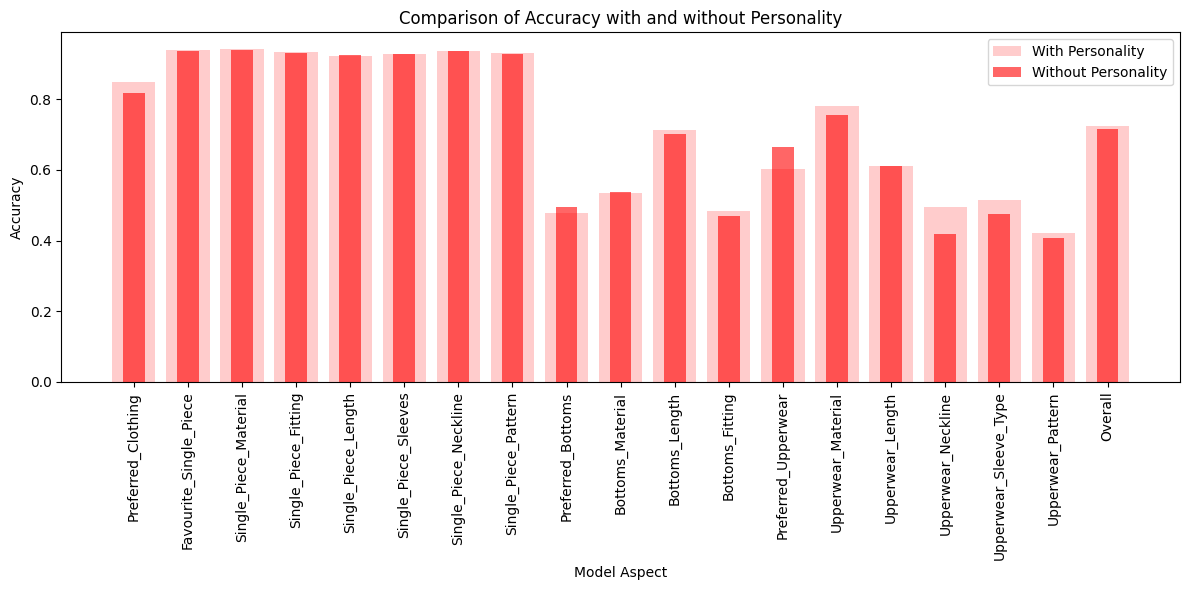

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load the data
eval_with_personality = pd.read_excel(os.path.join(excel_folder, 'model_eval_metrics_with_personality.xlsx'))
eval_without_personality = pd.read_excel(os.path.join(excel_folder, 'model_eval_metrics_without_personality.xlsx'))

# Metrics to be plotted
metrics = ["Accuracy"]

# Plotting the metrics
for metric in metrics:
    plt.figure(figsize=(12, 6))
    
    plt.bar(eval_with_personality['Column'], eval_with_personality[metric], alpha=0.2, color='r', label='With Personality', width=0.8)
    plt.bar(eval_without_personality['Column'], eval_without_personality[metric], alpha=0.6, color='r', label='Without Personality', width=0.4)
    plt.title(f'Comparison of {metric} with and without Personality')
    plt.xticks(rotation=90)
    plt.xlabel('Model Aspect')
    plt.ylabel(metric)
    plt.legend()
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(f'Comparison_{metric}.png')
    
    plt.show()


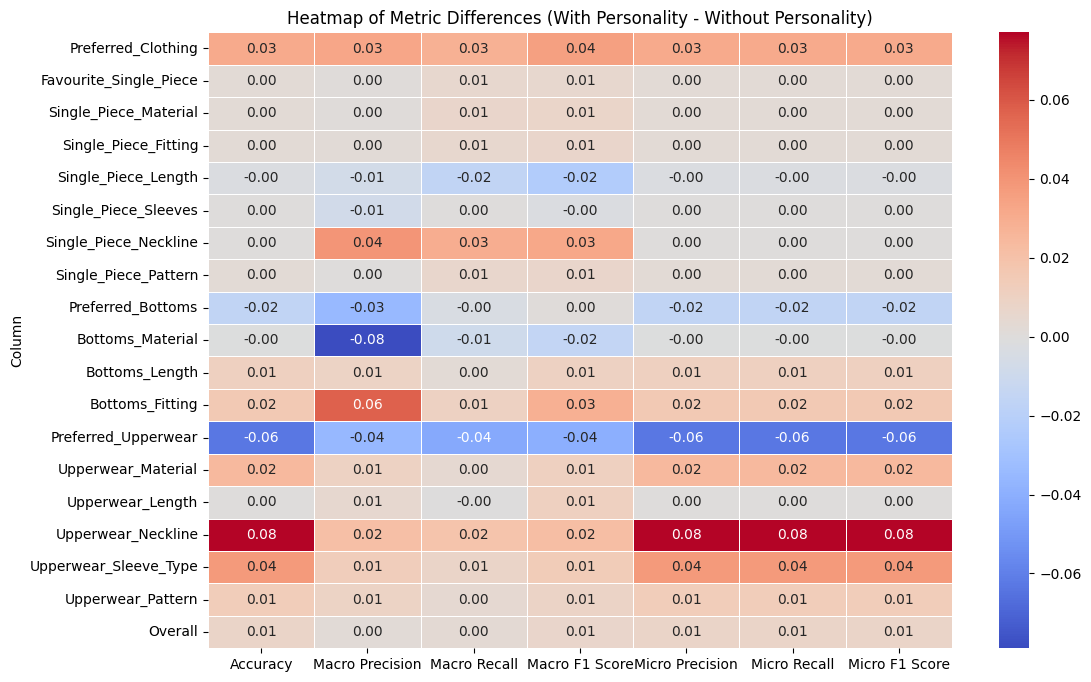

In [38]:
import seaborn as sns
# Metrics to be considered
metrics = ["Accuracy", "Macro Precision", "Macro Recall", "Macro F1 Score", "Micro Precision", "Micro Recall", "Micro F1 Score"]

# Calculate the difference between with and without personality
diff_df = eval_with_personality.copy()
for metric in metrics:
    diff_df[metric] = eval_with_personality[metric] - eval_without_personality[metric]

# Set the index to 'Column' for better visualization
diff_df.set_index('Column', inplace=True)

# Generate the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(diff_df[metrics], annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

plt.title('Heatmap of Metric Differences (With Personality - Without Personality)')
plt.show()

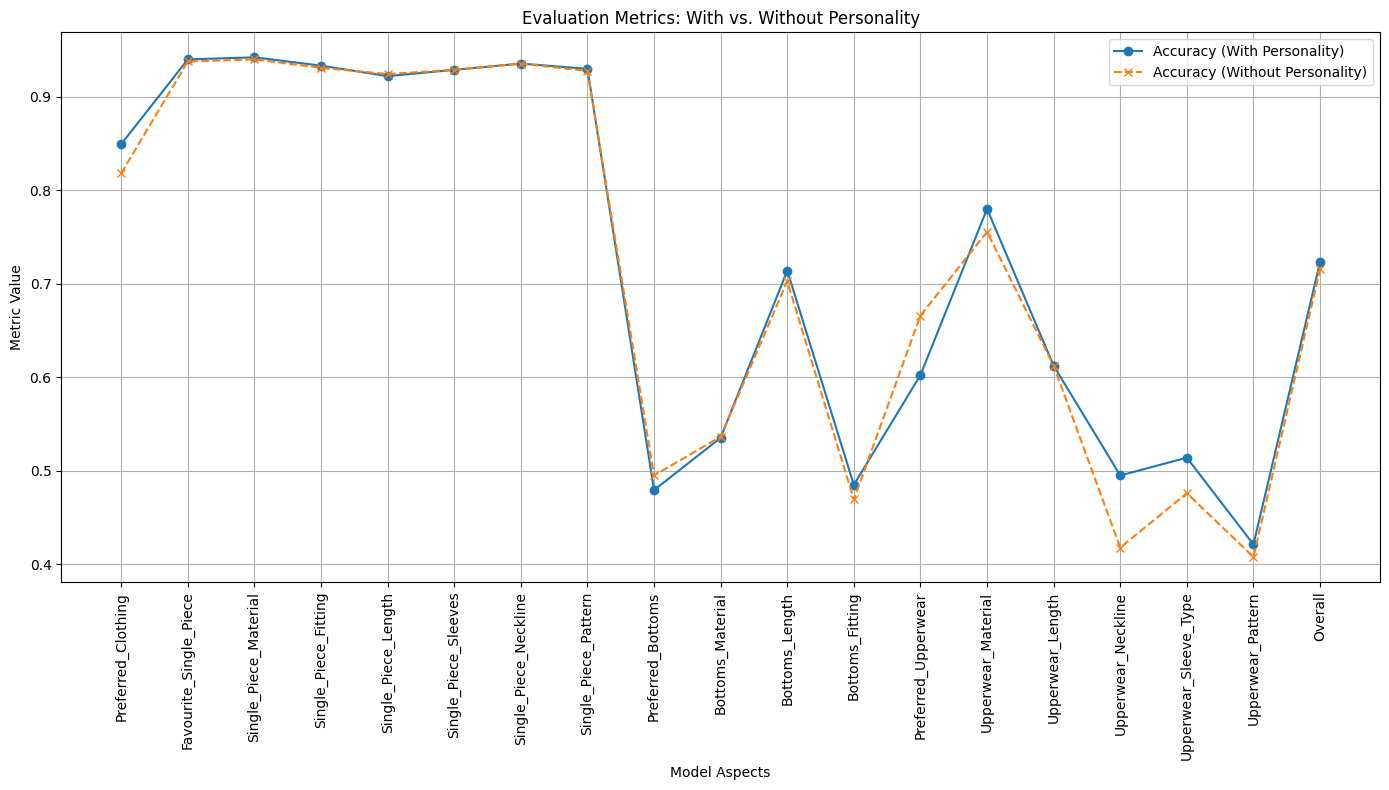

In [41]:
import pandas as pd
import matplotlib.pyplot as plt


# Set the index to 'Column' for better visualization
#eval_with_personality.set_index('Column', inplace=True)
#eval_without_personality.set_index('Column', inplace=True)

# Metrics to be considered
metrics = ["Accuracy"]

# Load the data
eval_with_personality = eval_with_personality[metrics]
eval_without_personality = eval_without_personality[metrics]


# Plotting line plots for each metric
plt.figure(figsize=(14, 8))

for metric in metrics:
    plt.plot(eval_with_personality.index, eval_with_personality[metric], marker='o', label=f'{metric} (With Personality)')
    plt.plot(eval_without_personality.index, eval_without_personality[metric], marker='x', linestyle='--', label=f'{metric} (Without Personality)')

plt.title('Evaluation Metrics: With vs. Without Personality')
plt.xlabel('Model Aspects')
plt.ylabel('Metric Value')
plt.xticks(rotation=90)
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


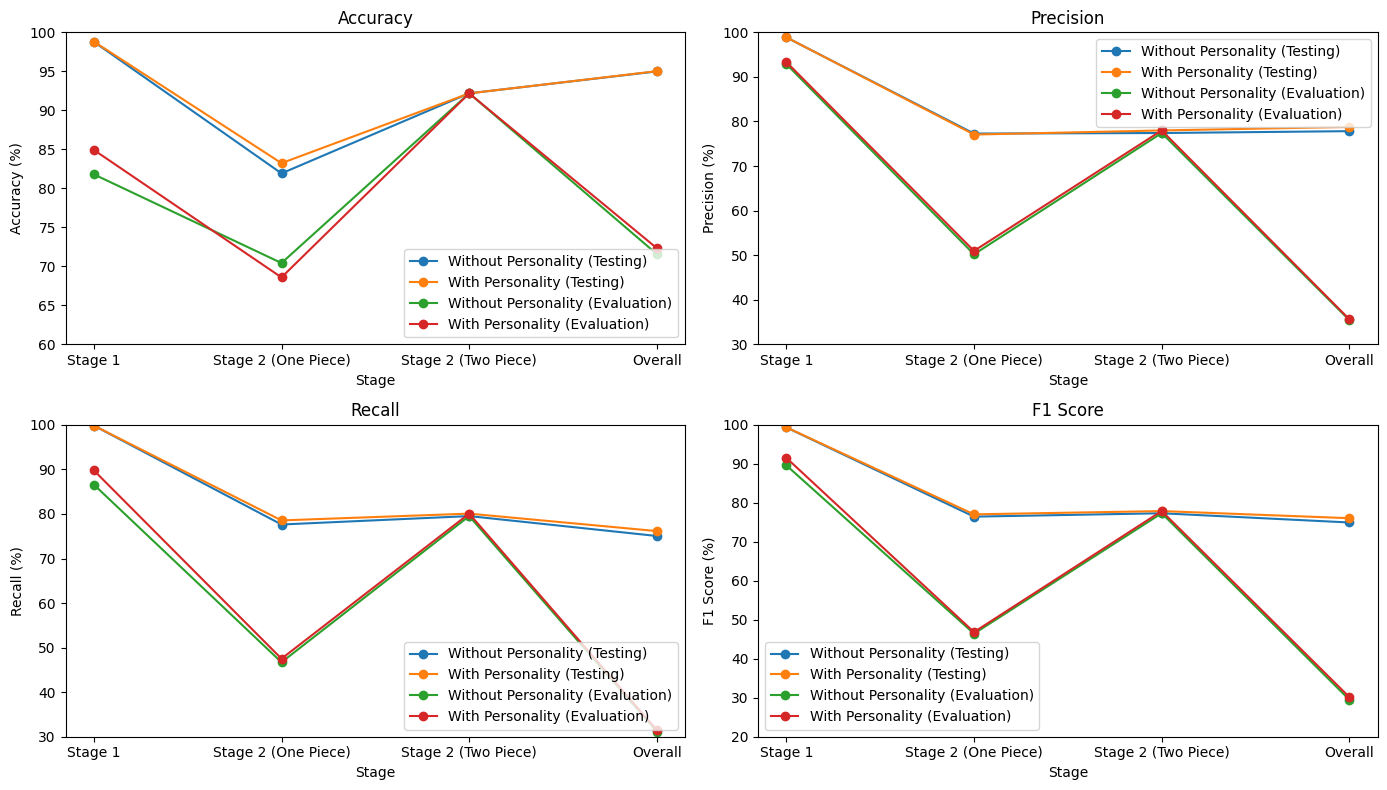

In [44]:
import matplotlib.pyplot as plt

# Data for plotting
stages = ['Stage 1', 'Stage 2 (One Piece)', 'Stage 2 (Two Piece)', 'Overall']

# Accuracy Data
accuracy_without_personality = [98.79, 81.91, 92.18, 94.99]
accuracy_with_personality = [98.82, 83.22, 92.17, 95.02]
accuracy_without_personality_eval = [81.79, 70.41, 92.18, 71.55]
accuracy_with_personality_eval = [84.92, 68.57, 92.17, 72.31]

# Precision Data
precision_without_personality = [98.87, 77.28, 77.40, 77.82]
precision_with_personality = [98.90, 77.06, 77.98, 78.77]
precision_without_personality_eval = [92.88, 50.18, 77.40, 35.40]
precision_with_personality_eval = [93.35, 50.94, 77.98, 35.59]

# Recall Data
recall_without_personality = [99.84, 77.63, 79.52, 75.05]
recall_with_personality = [99.84, 78.55, 80.07, 76.15]
recall_without_personality_eval = [86.59, 46.71, 79.52, 31.17]
recall_with_personality_eval = [89.79, 47.51, 80.07, 31.49]

# F1 Score Data
f1_without_personality = [99.35, 76.45, 77.32, 74.95]
f1_with_personality = [99.37, 77.04, 77.88, 76.05]
f1_without_personality_eval = [89.62, 46.44, 77.32, 29.49]
f1_with_personality_eval = [91.54, 46.84, 77.88, 30.15]

# Plotting Accuracy
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
plt.plot(stages, accuracy_without_personality, label='Without Personality (Testing)', marker='o')
plt.plot(stages, accuracy_with_personality, label='With Personality (Testing)', marker='o')
plt.plot(stages, accuracy_without_personality_eval, label='Without Personality (Evaluation)', marker='o')
plt.plot(stages, accuracy_with_personality_eval, label='With Personality (Evaluation)', marker='o')
plt.title('Accuracy')
plt.xlabel('Stage')
plt.ylabel('Accuracy (%)')
plt.ylim(60, 100)
plt.legend()

# Plotting Precision
plt.subplot(2, 2, 2)
plt.plot(stages, precision_without_personality, label='Without Personality (Testing)', marker='o')
plt.plot(stages, precision_with_personality, label='With Personality (Testing)', marker='o')
plt.plot(stages, precision_without_personality_eval, label='Without Personality (Evaluation)', marker='o')
plt.plot(stages, precision_with_personality_eval, label='With Personality (Evaluation)', marker='o')
plt.title('Precision')
plt.xlabel('Stage')
plt.ylabel('Precision (%)')
plt.ylim(30, 100)
plt.legend()

# Plotting Recall
plt.subplot(2, 2, 3)
plt.plot(stages, recall_without_personality, label='Without Personality (Testing)', marker='o')
plt.plot(stages, recall_with_personality, label='With Personality (Testing)', marker='o')
plt.plot(stages, recall_without_personality_eval, label='Without Personality (Evaluation)', marker='o')
plt.plot(stages, recall_with_personality_eval, label='With Personality (Evaluation)', marker='o')
plt.title('Recall')
plt.xlabel('Stage')
plt.ylabel('Recall (%)')
plt.ylim(30, 100)
plt.legend()

# Plotting F1 Score
plt.subplot(2, 2, 4)
plt.plot(stages, f1_without_personality, label='Without Personality (Testing)', marker='o')
plt.plot(stages, f1_with_personality, label='With Personality (Testing)', marker='o')
plt.plot(stages, f1_without_personality_eval, label='Without Personality (Evaluation)', marker='o')
plt.plot(stages, f1_with_personality_eval, label='With Personality (Evaluation)', marker='o')
plt.title('F1 Score')
plt.xlabel('Stage')
plt.ylabel('F1 Score (%)')
plt.ylim(20, 100)
plt.legend()

plt.tight_layout()
plt.show()


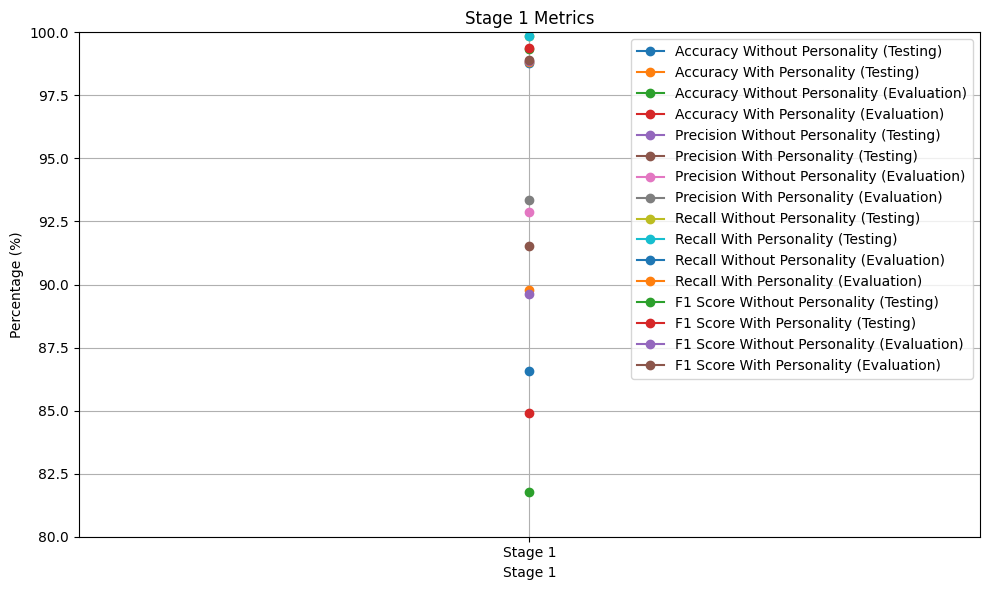

In [45]:
import matplotlib.pyplot as plt

# Data for plotting
stages = ['Stage 1']

# Stage 1 Data
accuracy_without_personality = [98.79]
accuracy_with_personality = [98.82]
accuracy_without_personality_eval = [81.79]
accuracy_with_personality_eval = [84.92]

precision_without_personality = [98.871]
precision_with_personality = [98.9029]
precision_without_personality_eval = [92.88]
precision_with_personality_eval = [93.35]

recall_without_personality = [99.8371]
recall_with_personality = [99.8371]
recall_without_personality_eval = [86.59]
recall_with_personality_eval = [89.79]

f1_without_personality = [99.3517]
f1_with_personality = [99.3678]
f1_without_personality_eval = [89.62]
f1_with_personality_eval = [91.54]

# Plotting all Stage 1 metrics on one graph
plt.figure(figsize=(10, 6))

plt.plot(stages, accuracy_without_personality, label='Accuracy Without Personality (Testing)', marker='o')
plt.plot(stages, accuracy_with_personality, label='Accuracy With Personality (Testing)', marker='o')
plt.plot(stages, accuracy_without_personality_eval, label='Accuracy Without Personality (Evaluation)', marker='o')
plt.plot(stages, accuracy_with_personality_eval, label='Accuracy With Personality (Evaluation)', marker='o')

plt.plot(stages, precision_without_personality, label='Precision Without Personality (Testing)', marker='o')
plt.plot(stages, precision_with_personality, label='Precision With Personality (Testing)', marker='o')
plt.plot(stages, precision_without_personality_eval, label='Precision Without Personality (Evaluation)', marker='o')
plt.plot(stages, precision_with_personality_eval, label='Precision With Personality (Evaluation)', marker='o')

plt.plot(stages, recall_without_personality, label='Recall Without Personality (Testing)', marker='o')
plt.plot(stages, recall_with_personality, label='Recall With Personality (Testing)', marker='o')
plt.plot(stages, recall_without_personality_eval, label='Recall Without Personality (Evaluation)', marker='o')
plt.plot(stages, recall_with_personality_eval, label='Recall With Personality (Evaluation)', marker='o')

plt.plot(stages, f1_without_personality, label='F1 Score Without Personality (Testing)', marker='o')
plt.plot(stages, f1_with_personality, label='F1 Score With Personality (Testing)', marker='o')
plt.plot(stages, f1_without_personality_eval, label='F1 Score Without Personality (Evaluation)', marker='o')
plt.plot(stages, f1_with_personality_eval, label='F1 Score With Personality (Evaluation)', marker='o')

plt.title('Stage 1 Metrics')
plt.xlabel('Stage 1')
plt.ylabel('Percentage (%)')
plt.ylim(80, 100)
plt.legend(loc='best')
plt.grid(True)

plt.tight_layout()
plt.show()
